In [1]:
import os
import sys
import time
import calendar
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy as sp
from scipy import stats
import tensorflow as tf

# from my_lib.field_config import data_encoder

# Setup

In [2]:
# ds_suffix = "vf10k"
ds_suffix = "-czech"
# max_seq_len = 80
# min_seq_len = 20

In [3]:

# gen_ds_file =  "generated_data/s-gen_num_layers_dec_4-d_model_128-num_heads_4-i_3-dr_0__1-dff_32-opt_adam-l_loss_mse_lwi-TC4X--vf1-len_40.csv"
# # gen_seq_len = 80
# gen_ds_file =  "generated_data/gen_num_layers_dec_4-d_model_128-num_heads_4-i_0-dr_0__1-dff_32-opt_adam-l_loss_mse_lwi-0--vf1-len_80.csv"

# fgen_file = "generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv" 

gen_ds_file = "generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv"
fgen_file = "generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv"
tg_file = "generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv"


gen_df = pd.read_csv(gen_ds_file, parse_dates=["date"])
gen_df["datetime"] = gen_df["date"]
gen_df

,Unnamed: 0,amount,k_symbol_num,operation_num,type_num,date_fields,days_passed,age,date,account_id,k_symbol,operation,type,tcode,datetime,raw_amount,raw_tcode
0,0,4716.28,0,0,0,01/31,0,47,1993-12-08,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1993-12-08,4716.28,nan__CREDIT IN CASH__CREDIT
1,1,7273.42,0,0,0,01/31,4,47,1993-12-12,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1993-12-12,7273.42,nan__CREDIT IN CASH__CREDIT
2,2,92.78,1,2,0,01/01,19,47,1993-12-31,0,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,1993-12-31,92.78,INTEREST CREDITED__nan__CREDIT
3,3,7178.21,0,0,0,01/31,8,47,1994-01-08,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1994-01-08,7178.21,nan__CREDIT IN CASH__CREDIT
4,4,8915.65,0,0,0,01/31,3,47,1994-01-11,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1994-01-11,8915.65,nan__CREDIT IN CASH__CREDIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,499975,5164.42,0,3,1,01/31,10,31,1998-11-15,4999,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,1998-11-15,-5164.42,nan__CASH WITHDRAWAL__DEBIT
399996,499976,15233.14,0,0,0,01/31,3,31,1998-11-18,4999,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1998-11-18,15233.14,nan__CREDIT IN CASH__CREDIT
399997,499977,7378.34,0,3,1,01/01,7,31,1998-11-25,4999,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,1998-11-25,-7378.34,nan__CASH WITHDRAWAL__DEBIT
399998,499978,5054.12,0,3,1,01/01,1,31,1998-11-26,4999,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,1998-11-26,-5054.12,nan__CASH WITHDRAWAL__DEBIT


In [4]:
real_df = pd.read_csv(f"real_data/final_df--czech.csv", parse_dates=["datetime"])
real_df["days_passed"] = real_df["td"]
real_df

,Unnamed: 0,Unnamed: 0.1,column_a,account_id,date,type,operation,amount,balance,k_symbol,...,datetime,month,day,dow,year,td,dtme,doy,raw_amount,days_passed
0,0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,...,1995-03-24,3,24,4,1995,0.0,7,83,1000.0,0.0
1,1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,...,1995-04-13,4,13,3,1995,20.0,17,103,3679.0,20.0
2,2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,...,1995-04-23,4,23,6,1995,10.0,7,113,12600.0,10.0
3,3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,...,1995-04-30,4,30,6,1995,7.0,0,120,19.2,7.0
4,4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,...,1995-05-13,5,13,5,1995,13.0,18,133,3679.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,1056315,1056315,1033141,11382,981202,DEBIT,CASH WITHDRAWAL,25600.0,41114.4,NaN,...,1998-12-02,12,2,2,1998,2.0,29,336,-25600.0,2.0
1056316,1056316,1056316,1040574,11382,981210,CREDIT,COLLECTION FROM ANOTHER BANK,46248.0,87362.4,NaN,...,1998-12-10,12,10,3,1998,8.0,21,344,46248.0,8.0
1056317,1056317,1056317,1050362,11382,981225,DEBIT,CASH WITHDRAWAL,6300.0,81062.4,NaN,...,1998-12-25,12,25,4,1998,15.0,6,359,-6300.0,15.0
1056318,1056318,1056318,1053037,11382,981231,CREDIT,NaN,311.3,81373.6,INTEREST CREDITED,...,1998-12-31,12,31,3,1998,6.0,0,365,311.3,6.0


In [5]:
real_df.tcode = real_df.tcode.apply(lambda x: x.replace("$  $", "--"))

In [6]:
gen_df.tcode = gen_df.tcode.apply(lambda x: x.replace("$  $", "--"))

In [7]:


real_df["Amount"] = real_df.amount
real_df.amount = real_df.amount.apply(abs)


In [8]:
def describe(x):
    fns = ["mean", "median", "std", "min", "max"]
    for fn in fns:
        val = eval(f"np.{fn}(x)")
        print(f"{fn} is {val:.2f},", end="\t")
        
    fn = "log_abs_mean" 
    val = np.mean(np.log10(np.abs(x)+1.))
    print(f"{fn} is {val:.2f},")


In [9]:

fgen_df = pd.read_csv(fgen_file, parse_dates=["datetime"])
fgen_df["tcode"] = fgen_df.tcode.apply(lambda x: x.replace("---", "--"))
fgen_df.tcode.unique()

array(['nan__CREDIT IN CASH__CREDIT', 'nan__CASH WITHDRAWAL__DEBIT',
       'INTEREST CREDITED__nan__CREDIT',
       'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT',
       'OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT',
       'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT',
       ' __REMITTANCE TO ANOTHER BANK__DEBIT',
       'INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT',
       'nan__CREDIT CARD WITHDRAWAL__DEBIT',
       'nan__COLLECTION FROM ANOTHER BANK__CREDIT',
       'LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT',
       'nan__REMITTANCE TO ANOTHER BANK__DEBIT',
       'HOUSEHOLD__CASH WITHDRAWAL__DEBIT',
       'SANCTION INTEREST__CASH WITHDRAWAL__DEBIT',
       'INSURANCE PAYMENT__CASH WITHDRAWAL__DEBIT',
       ' __CASH WITHDRAWAL__DEBIT'], dtype=object)

In [10]:
fgen_df.columns

Index(['Unnamed: 0', 'unnamed: 0', 'tcode', 'amount', 'balance', 'age', 'dif',
       'account_id', 'date', 'date.1', 'cum_dif', 'days_passed', 'short_tcode',
       'raw_tcode', 'k_symbol', 'operation', 'type', 'datetime', 'raw_amount'],
      dtype='object')

In [11]:

tg_df = pd.read_csv(tg_file, parse_dates=['datetime'])
tg_df["days_passed"] = tg_df["td"]
# tg_df["tcode"] = fgen_df.tcode.apply(lambda x: x.replace("---", "--"))
tg_df

,k_symbol_num,operation_num,type_num,td,amount,age,account_id,datetime,k_symbol,operation,type,tcode,raw_amount,days_passed
0,0,2,0,4.0,104.25,44.0,0,1996-04-17,NaN,NaN,CREDIT,nan__nan__CREDIT,104.25,4.0
1,0,3,1,18.0,288.76,44.0,0,1996-05-05,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,-288.76,18.0
2,1,2,0,4.0,81.29,44.0,0,1996-05-09,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,81.29,4.0
3,0,0,0,9.0,14286.56,44.0,0,1996-05-18,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,14286.56,9.0
4,0,4,1,-1.0,3936.29,44.0,0,1996-05-17,NaN,REMITTANCE TO ANOTHER BANK,DEBIT,nan__REMITTANCE TO ANOTHER BANK__DEBIT,-3936.29,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,1,2,0,15.0,100.05,44.0,4999,1997-05-27,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,100.05,15.0
399996,1,2,0,5.0,17.60,44.0,4999,1997-06-01,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,17.60,5.0
399997,2,3,1,2.0,0.24,44.0,4999,1997-06-03,PAYMENT ON STATEMENT,CASH WITHDRAWAL,DEBIT,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,-0.24,2.0
399998,1,3,0,2.0,0.41,44.0,4999,1997-06-05,INTEREST CREDITED,CASH WITHDRAWAL,CREDIT,INTEREST CREDITED__CASH WITHDRAWAL__CREDIT,0.41,2.0


## Setup

In [12]:



def compare_distributions(tables, labels):

    # fig, ax = plt.subplots(1, 3, )

    # bars = ["tcode"]
    width = 0.25
    bins = 50
    eps = 1

    col = "tcode"
    uniq = real_df[col].unique()

    plt_dp = True
    for t in tables:
        if "days_passed" not in t: plt_dp = False
                
                
    if plt_dp:
        fig, ax = plt.subplots(1,4, figsize=(20,5))
    else:
        fig, ax = plt.subplots(1,3, figsize=(18,5))

    for t_i, (table, plt_lbl) in enumerate(zip(tables, labels)):

        counts = []
        lbls = []

        for j, val in enumerate(uniq):

            l = sum(table[col] == val)
            counts.append(l)
            lbls.append(val)

    #     for count, lbl in zip(counts, lbls):

        x = np.arange(len(lbls)) + t_i*width # the label locations
        ps = [x/sum(counts) for x in counts]
        rects1 = ax[0].bar(x - width/2, ps, width, align="edge", label=plt_lbl)


        ax[0].set_xticks(x)
        ax[0].set_xticklabels(lbls, rotation=75)
        ax[0].set_title("Tcode Frequency")


        ax[1].hist(table["amount"], bins=bins, density=True, alpha=0.5, label=plt_lbl)
        ax[1].set_title("Amounts Distribution")

        log_amts = table["amount"]+eps
        log_amts[log_amts<eps] = eps
        
        ax[2].hist(np.log10(log_amts), bins=bins, density=True, alpha=0.5, label=plt_lbl)
        ax[2].set_title("Log Amounts Distribution")
        
        if plt_dp:
            ax[3].hist(table["days_passed"], bins=50, range=(0,50), label=plt_lbl, alpha=0.5, density=True)
            ax[3].set_title("Days passed Distribution (<50)")
          

    for a in ax:
        a.legend()

    plt.show()
    
    

def plot_time_heatmap(df, log = False, eps = 1., showbig=False, show_by_month = True, print_info = False):

    rows = end.year - start.year +1
    cols = 365

    hm = np.zeros((rows, cols))
    leap_year_trs = 0.
    past_end_trs = 0.
    
    
    if not "datetime" in df:
#         print()
        df["datetime"] = parse_date(df["date"])
        

    for date in df["datetime"]:
        r = date.year - start.year

        try:
            c = datetime.date(1993, date.month, date.day) - datetime.date(1993, 1, 1)  # treat all years as non-leap
            c = c.days

            hm[r,c] += 1.
        except:
            if date.day == 29 and date.month == 2:
                leap_year_trs += 1
            elif date.year > end.year:
                past_end_trs += 1
            else:
                raise Exception(f"Failed with: {date}")
            
    if log:
        hm = np.log10(hm + eps)
 
    if print_info:
        print(f"{leap_year_trs} on Feb 29th")
        print(f"{past_end_trs} past 1998")
        
    if showbig:
        plt.figure(figsize=(20,5))
        plt.matshow(hm, fignum=1, aspect='auto') 
        plt.show()
    
    if not show_by_month: 
        return hm
    
    r = 4
    c = 3

    fig, ax = plt.subplots(r, c, figsize=(18, 8))

    start_i = 0

    for month in range(1, 13):

        end_i = start_i + calendar.monthrange(1, month)[1] # non-leap year

        ax[(month-1)//c, (month-1)%c].matshow(hm[:, start_i:end_i], aspect="auto")
        ax[(month-1)//c, (month-1)%c].set_title(calendar.month_name[month])
        start_i = end_i


    plt.tight_layout()
    plt.show()    
    
    return hm


def plt_tr_density_by_time(hms, labels):
    
    plt.figure(figsize=(18,5))  
    
    for t_i, (hm, plt_lbl) in enumerate(zip(hms, labels)):
        
        plt.plot(np.sum(hm, axis=0)/np.sum(hm), label=plt_lbl)

 

start, end = real_df["datetime"].min().date(), real_df["datetime"].max().date()
print("start, end = ", start, end)
ALL_DAYS = [start + datetime.timedelta(i) for i in range((end - start).days)]

start, end =  1993-01-01 1998-12-31


# Compare Times
Note: This isn't included in paper

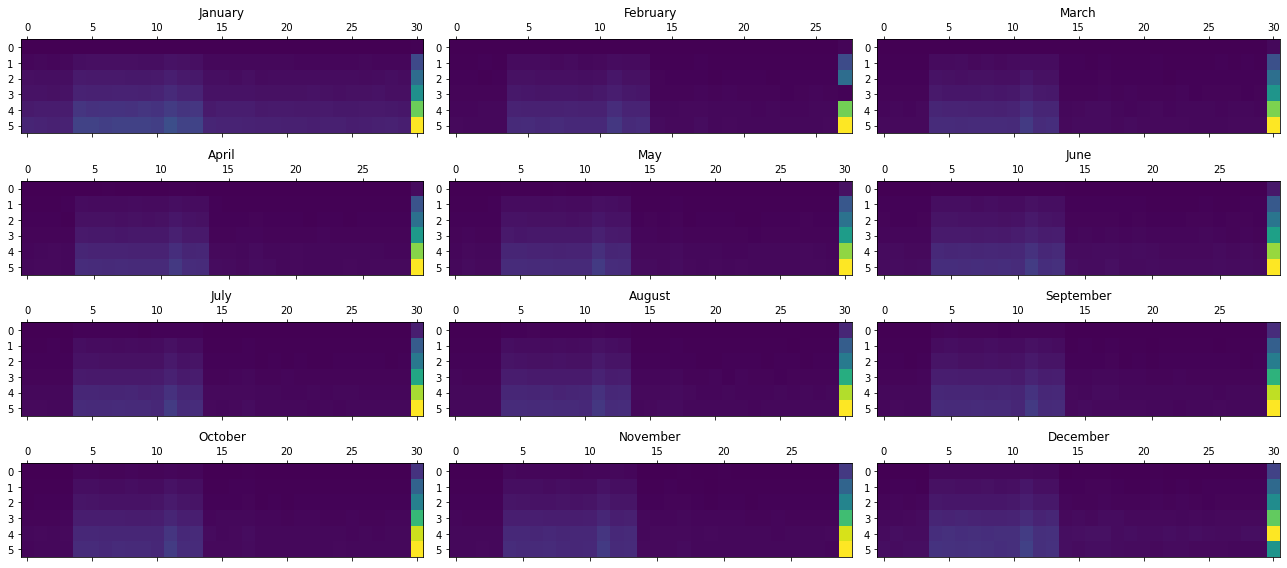

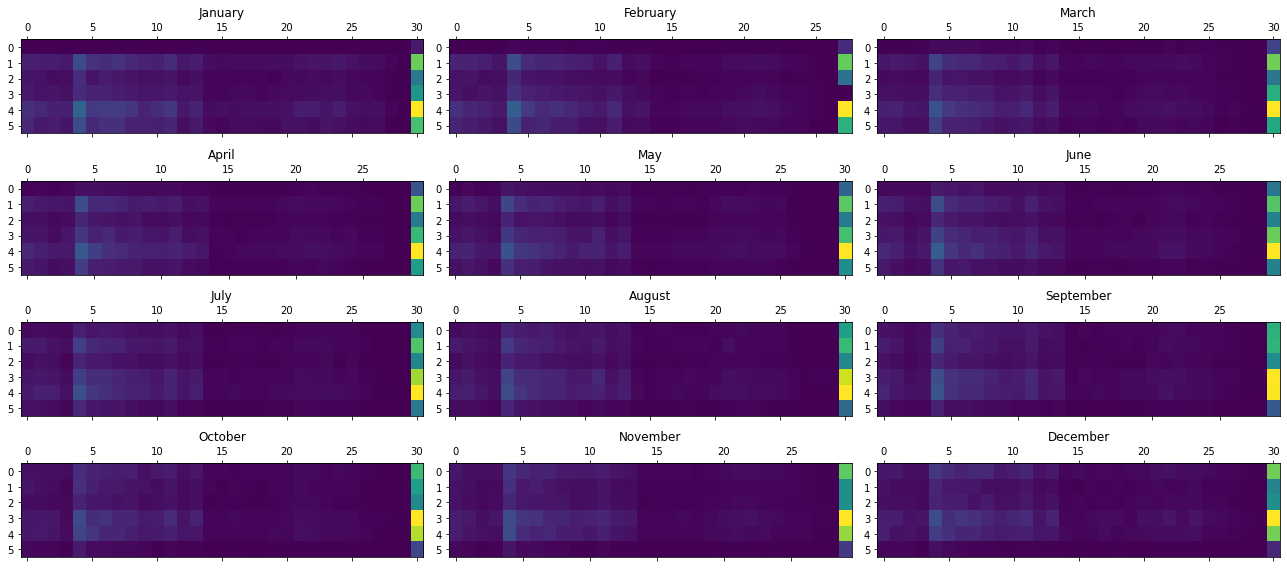

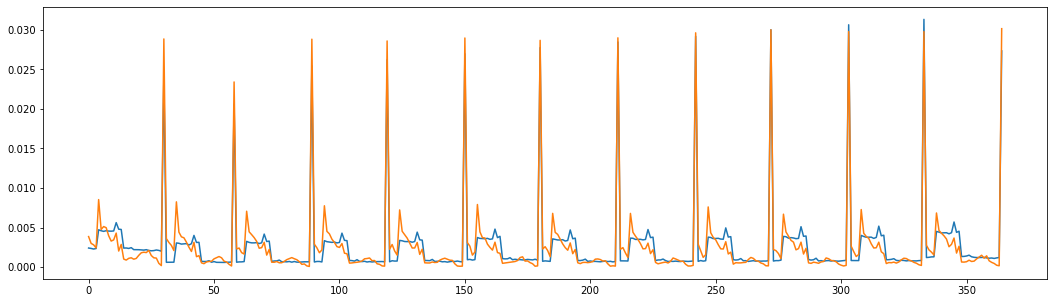

In [13]:
hm_real = plot_time_heatmap(real_df)
# compare_distributions(tables= [real_df, gen_df], labels=["Real", "Gen"])
hm_gen = plot_time_heatmap(gen_df)
plt_tr_density_by_time([hm_real, hm_gen], ["Real", "Gen"])
plt.show()

In [14]:
real_df.date.min(), real_df.date.max()

(930101, 981231)

# PCA

## Setup

required fields = ["tcode", "amount", "account_id", "days_passed", "age" ] 

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
# unique_tcodes = real_df.tcode.unique().tolist()
# tcode_to_num = lambda x: unique_tcodes.index(x)

# tcode_nums_r = real_df["tcode"].apply(tcode_to_num)
# tcode_nums_g = gen_df["tcode"].apply(tcode_to_num)

In [17]:
x = y = 4
x, y

(4, 4)

In [18]:
# tcode_order = np.array(list(set(list(real_df.tcode.unique())  + list(gen_df.tcode.unique()))))

# set(fgen_df.tcode.unique())

s = set()
for df in [real_df, gen_df, fgen_df, tg_df]:
    s = s.union( set(list(df.tcode.unique())) )
    

tcode_order =  list(s)
tcode_to_num = lambda x: tcode_order.index(x)
    
    
# tcode_order =  np.array(list(s))
# tcode_nums_r = real_df["tcode"].apply(lambda x: np.where(tcode_order==x)[0][0])
# tcode_nums_g = gen_df["tcode"].apply(lambda x: np.where(tcode_order==x)[0][0])

tcode_nums_r = real_df["tcode"].apply(tcode_to_num)
tcode_nums_g = gen_df["tcode"].apply(tcode_to_num)
tcode_nums_f = fgen_df["tcode"].apply(tcode_to_num)
tcode_nums_t = tg_df["tcode"].apply(tcode_to_num)

In [19]:
oh_r = tf.one_hot(tcode_nums_r, depth=len(tcode_order))
oh_g = tf.one_hot(tcode_nums_g, depth=len(tcode_order))
oh_f = tf.one_hot(tcode_nums_f, depth=len(tcode_order))
oh_t = tf.one_hot(tcode_nums_t, depth=len(tcode_order))

2022-04-05 09:55:20.569544: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
data_r = np.concatenate([np.array(real_df["amount"])[:,None], oh_r.numpy()], axis=1)
data_r.shape

(1056320, 67)

In [21]:
data_g = np.concatenate([np.array(gen_df["amount"])[:,None], oh_g.numpy()], axis=1)
data_g.shape

(400000, 67)

In [22]:
data_f = np.concatenate([np.array(fgen_df["amount"])[:,None], oh_f.numpy()], axis=1)
data_f.shape

(951466, 67)

In [23]:
data_t = np.concatenate([np.array(tg_df["amount"])[:,None], oh_t.numpy()], axis=1)
data_t.shape

(400000, 67)

In [24]:
tcode_names = tcode_order #[data_encoder.NUM_TO_TCODE[i] for i in range(data_encoder.n_tcodes)]

In [25]:
real_trans_df = pd.DataFrame.from_records(data_r, columns=["amount"] + tcode_names)
real_trans_df["account_id"] = real_df["account_id"]
real_trans_df["age"] = real_df["age"]
real_trans_df["log_amount"] = np.log10(real_trans_df["amount"]+1)

AMOUNT_SCALE = real_trans_df["amount"].std()
LOG_AMOUNT_SCALE = real_trans_df["log_amount"].std()

real_trans_df["amount_sc"] = real_trans_df["amount"] / AMOUNT_SCALE
real_trans_df["log_amount_sc"] = real_trans_df["log_amount"] / LOG_AMOUNT_SCALE

real_trans_df["days_passed"] = real_df["days_passed"]

real_trans_df

,amount,nan__CASH WITHDRAWAL__CREDIT,LOAN PAYMENT__CASH WITHDRAWAL__DEBIT,__CREDIT IN CASH__CREDIT,SANCTION INTEREST__CREDIT IN CASH__CREDIT,nan__nan__CREDIT,INTEREST CREDITED__REMITTANCE TO ANOTHER BANK__CREDIT,OLD AGE PENSION__REMITTANCE TO ANOTHER BANK__DEBIT,HOUSEHOLD__nan__DEBIT,INTEREST CREDITED__nan__DEBIT,...,INTEREST CREDITED__nan__CREDIT,LOAN PAYMENT__COLLECTION FROM ANOTHER BANK__DEBIT,LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__CREDIT,INSURANCE PAYMENT__CREDIT IN CASH__CREDIT,account_id,age,log_amount,amount_sc,log_amount_sc,days_passed
0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,29,3.000434,0.105012,2.823750,0.0
1,3679.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,29,3.565848,0.386339,3.355869,20.0
2,12600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,29,4.100405,1.323149,3.858949,10.0
3,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1,29,1.305351,0.002016,1.228484,7.0
4,3679.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,29,3.565848,0.386339,3.355869,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,25600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11382,46,4.408257,2.688303,4.148672,2.0
1056316,46248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11382,46,4.665102,4.856588,4.390393,8.0
1056317,6300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11382,46,3.799409,0.661575,3.575677,15.0
1056318,311.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,11382,46,2.494572,0.032690,2.347677,6.0


In [26]:
gen_trans_df = pd.DataFrame.from_records(data_g, columns=["amount"] + tcode_names)
gen_trans_df["age"] = gen_df["age"]
gen_trans_df["account_id"] = gen_df["account_id"]
gen_trans_df["log_amount"] = np.log10(gen_trans_df["amount"]+1)

gen_trans_df["amount_sc"] = gen_trans_df["amount"] / AMOUNT_SCALE
gen_trans_df["log_amount_sc"] = gen_trans_df["log_amount"] / LOG_AMOUNT_SCALE

gen_trans_df["days_passed"] = gen_df["days_passed"]

gen_trans_df

,amount,nan__CASH WITHDRAWAL__CREDIT,LOAN PAYMENT__CASH WITHDRAWAL__DEBIT,__CREDIT IN CASH__CREDIT,SANCTION INTEREST__CREDIT IN CASH__CREDIT,nan__nan__CREDIT,INTEREST CREDITED__REMITTANCE TO ANOTHER BANK__CREDIT,OLD AGE PENSION__REMITTANCE TO ANOTHER BANK__DEBIT,HOUSEHOLD__nan__DEBIT,INTEREST CREDITED__nan__DEBIT,...,INTEREST CREDITED__nan__CREDIT,LOAN PAYMENT__COLLECTION FROM ANOTHER BANK__DEBIT,LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__CREDIT,INSURANCE PAYMENT__CREDIT IN CASH__CREDIT,age,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,4716.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,47,0,3.673692,0.495265,3.457363,0
1,7273.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,47,0,3.861798,0.763795,3.634392,4
2,92.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,47,0,1.972110,0.009743,1.855981,19
3,7178.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,47,0,3.856077,0.753797,3.629008,8
4,8915.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,47,0,3.950202,0.936249,3.717590,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,5164.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31,4999,3.713106,0.542325,3.494456,10
399996,15233.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31,4999,4.182818,1.599660,3.936508,3
399997,7378.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31,4999,3.868018,0.774813,3.640245,7
399998,5054.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31,4999,3.703731,0.530742,3.485633,1


In [27]:
fgen_trans_df = pd.DataFrame.from_records(data_f, columns=["amount"] + tcode_names)
fgen_trans_df["age"] = 0# fgen_df["age"]
fgen_trans_df["account_id"] = fgen_df["account_id"]
fgen_trans_df["log_amount"] = np.log10(fgen_trans_df["amount"]+1)

fgen_trans_df["amount_sc"] = fgen_trans_df["amount"] / AMOUNT_SCALE
fgen_trans_df["log_amount_sc"] = fgen_trans_df["log_amount"] / LOG_AMOUNT_SCALE

fgen_trans_df["days_passed"] = fgen_df["days_passed"]

fgen_trans_df

,amount,nan__CASH WITHDRAWAL__CREDIT,LOAN PAYMENT__CASH WITHDRAWAL__DEBIT,__CREDIT IN CASH__CREDIT,SANCTION INTEREST__CREDIT IN CASH__CREDIT,nan__nan__CREDIT,INTEREST CREDITED__REMITTANCE TO ANOTHER BANK__CREDIT,OLD AGE PENSION__REMITTANCE TO ANOTHER BANK__DEBIT,HOUSEHOLD__nan__DEBIT,INTEREST CREDITED__nan__DEBIT,...,INTEREST CREDITED__nan__CREDIT,LOAN PAYMENT__COLLECTION FROM ANOTHER BANK__DEBIT,LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__CREDIT,INSURANCE PAYMENT__CREDIT IN CASH__CREDIT,age,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,67.019015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,1.832630,0.007038,1.724714,0.295632
1,22742.578145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,4.356859,2.388240,4.100301,0.664504
2,2087.511071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,3.319837,0.219213,3.124345,0.767858
3,19.560325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,1.313030,0.002054,1.235711,0.678287
4,6.236274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0,0.0,0.859515,0.000655,0.808902,0.630344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951461,6.722126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0,4999.0,0.887737,0.000706,0.835462,0.523607
951462,6.629063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,4999.0,0.882471,0.000696,0.830506,0.505409
951463,8.933729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0,4999.0,0.997112,0.000938,0.938396,0.445370
951464,146.264988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,4999.0,2.168100,0.015360,2.040429,0.424304


In [28]:
tg_trans_df = pd.DataFrame.from_records(data_t, columns=["amount"] + tcode_names)
tg_trans_df["age"] = 0# fgen_df["age"]
tg_trans_df["account_id"] = tg_df["account_id"]
tg_trans_df["log_amount"] = np.log10(tg_trans_df["amount"]+1)

tg_trans_df["amount_sc"] = tg_trans_df["amount"] / AMOUNT_SCALE
tg_trans_df["log_amount_sc"] = tg_trans_df["log_amount"] / LOG_AMOUNT_SCALE

tg_trans_df["days_passed"] = tg_df["days_passed"]

tg_trans_df

,amount,nan__CASH WITHDRAWAL__CREDIT,LOAN PAYMENT__CASH WITHDRAWAL__DEBIT,__CREDIT IN CASH__CREDIT,SANCTION INTEREST__CREDIT IN CASH__CREDIT,nan__nan__CREDIT,INTEREST CREDITED__REMITTANCE TO ANOTHER BANK__CREDIT,OLD AGE PENSION__REMITTANCE TO ANOTHER BANK__DEBIT,HOUSEHOLD__nan__DEBIT,INTEREST CREDITED__nan__DEBIT,...,INTEREST CREDITED__nan__CREDIT,LOAN PAYMENT__COLLECTION FROM ANOTHER BANK__DEBIT,LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__CREDIT,INSURANCE PAYMENT__CREDIT IN CASH__CREDIT,age,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,104.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,2.022222,0.010947,1.903142,4.0
1,288.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,2.462038,0.030323,2.317059,18.0
2,81.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0,0,1.915347,0.008536,1.802560,4.0
3,14286.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,4.154958,1.500258,3.910289,9.0
4,3936.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,3.595197,0.413357,3.383491,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,100.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0,4999,2.004536,0.010506,1.886497,15.0
399996,17.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0,4999,1.269513,0.001848,1.194756,5.0
399997,0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,4999,0.093422,0.000025,0.087920,2.0
399998,0.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,4999,0.149219,0.000043,0.140432,2.0


In [29]:
real_seq_df = real_trans_df.groupby("account_id").mean()
gen_seq_df = gen_trans_df.groupby("account_id").mean()
fgen_seq_df = fgen_trans_df.groupby("account_id").mean()
tg_seq_df = tg_trans_df.groupby("account_id").mean()

### dg data setup

# Seqpca

In [30]:
cols = tcode_names + ["amount", "days_passed"]

scaler = StandardScaler()

scaled_seqs_r = scaler.fit_transform(real_seq_df[cols])
scaled_seqs_g = scaler.transform(gen_seq_df[cols])
scaled_seqs_f = scaler.transform(fgen_seq_df[cols])
scaled_seqs_t = scaler.transform(tg_seq_df[cols])

pca = PCA()

scaled_seqs_r_pc = pca.fit_transform(scaled_seqs_r)

scaled_seqs_g_pc = pca.transform(scaled_seqs_g)
scaled_seqs_f_pc = pca.transform(scaled_seqs_f)
scaled_seqs_t_pc = pca.transform(scaled_seqs_t)

In [31]:


df0 = pd.DataFrame.from_records(scaled_seqs_r_pc[:,:2], columns=["PC1", "PC2"])
df0["src"] = "real"

df1 = pd.DataFrame.from_records(scaled_seqs_g_pc[:,:2], columns=["PC1", "PC2"])
df1["src"] = "gen"

df2 = pd.DataFrame.from_records(scaled_seqs_f_pc[:,:2], columns=["PC1", "PC2"])
df2["src"] = "fgen"


df3 = pd.DataFrame.from_records(scaled_seqs_t_pc[:,:2], columns=["PC1", "PC2"])
df3["src"] = "tg"

pcs_scaled = pd.concat([df0, df1, df2, df3]).reset_index()

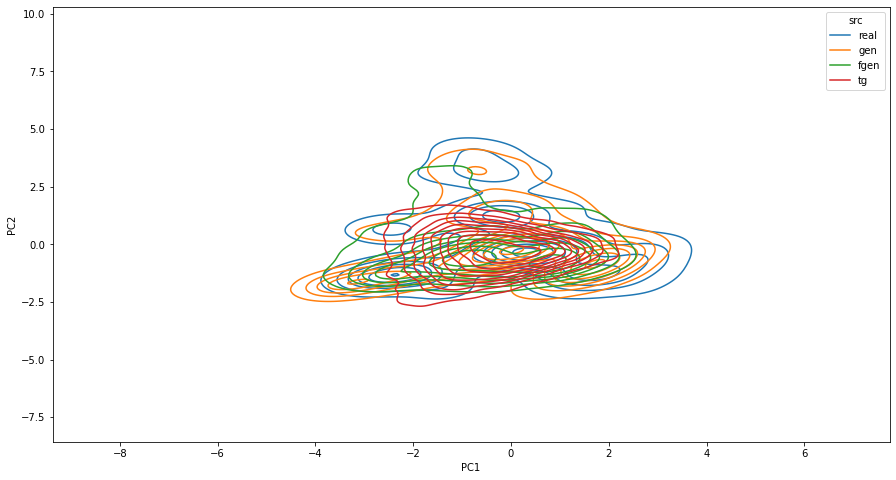

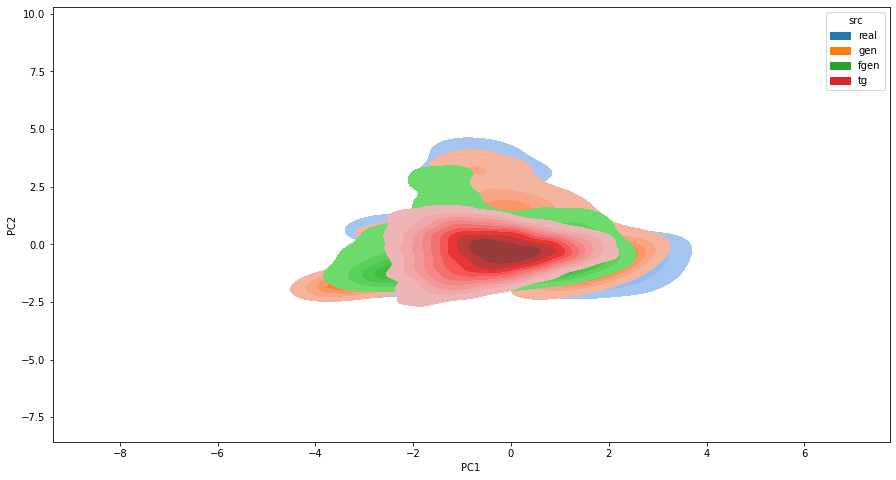

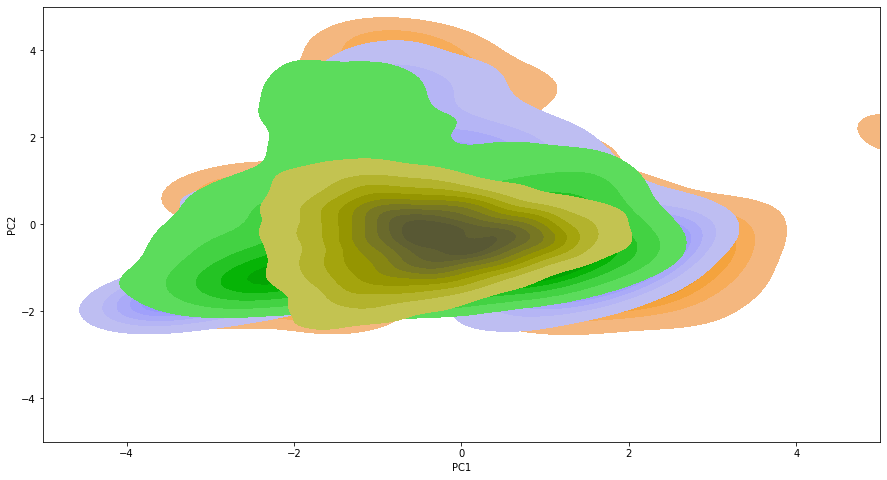

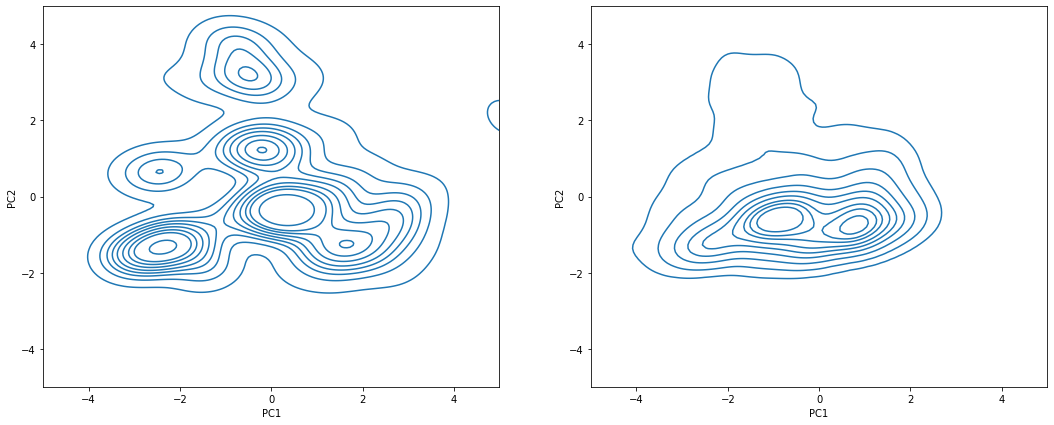

In [32]:
plt.figure(figsize=(15, 8))
sns.kdeplot(data=pcs_scaled, x="PC1", y="PC2", hue="src")

plt.figure(figsize=(15, 8))
sns.kdeplot(data=pcs_scaled, x="PC1", y="PC2", hue="src", fill=True)

plt.figure(figsize=(15, 8))
plt.ylim([-5,5])
plt.xlim([-5,5])
# plt.ylim([-5,5])
# plt.xlim([-5,5])
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2", fill=True, color="orange")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2", fill=True, color="b")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2", fill=True, color="g")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="tg"], x="PC1", y="PC2", fill=True, color="y")


fig, ax = plt.subplots(1,2, figsize=(18, 7))
ax[0].set_ylim([-5,5])
ax[0].set_xlim([-5,5])
ax[1].set_ylim([-5,5])
ax[1].set_xlim([-5,5])
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[0])
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[1])
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[1])



plt.show()

# fig, ax = plt.subplots(1,2, figsize=(18, 7))
# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[0], fill=True)
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[1], fill=True)

# plt.show()

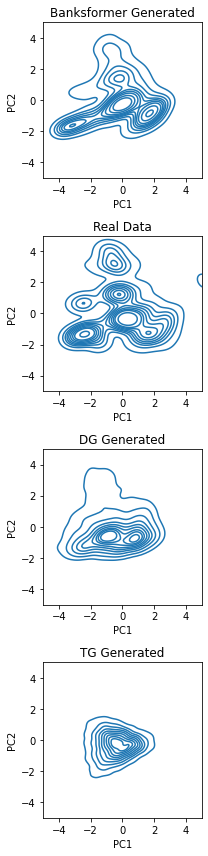

In [33]:
fig, ax = plt.subplots(4,1, figsize=(3,12))
ax[0].set_ylim([-5,5])
ax[0].set_xlim([-5,5])
ax[1].set_ylim([-5,5])
ax[1].set_xlim([-5,5])
ax[2].set_ylim([-5,5])
ax[2].set_xlim([-5,5])
ax[3].set_ylim([-5,5])
ax[3].set_xlim([-5,5])

sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
ax[0].set_title("Banksformer Generated")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
ax[1].set_title("Real Data")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
ax[2].set_title("DG Generated")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="tg"], x="PC1", y="PC2",ax=ax[3])
ax[3].set_title("TG Generated")
plt.tight_layout()

### Figure

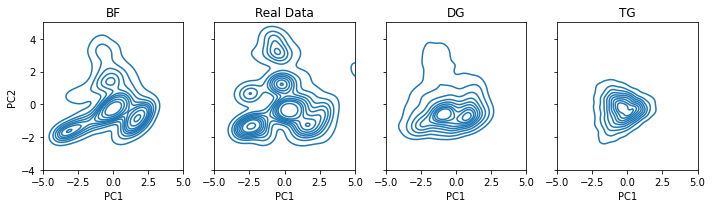

In [36]:
fig, ax = plt.subplots(1,4, figsize=(10,3), sharex=True, sharey=True)
ax[0].set_ylim([-4,5])
ax[0].set_xlim([-5,5])
ax[1].set_ylim([-4,5])
ax[1].set_xlim([-5,5])
ax[2].set_ylim([-4,5])
ax[2].set_xlim([-5,5])
ax[3].set_ylim([-4,5])
ax[3].set_xlim([-5,5])

# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
# ax[0].set_title("Banksformer Generated")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
# ax[1].set_title("Real Data")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
# ax[2].set_title("DG Generated")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="tg"], x="PC1", y="PC2",ax=ax[3])
# ax[3].set_title("TG Generated")
# plt.tight_layout()



sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
ax[0].set_title("BF")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
ax[1].set_title("Real Data")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
ax[2].set_title("DG")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="tg"], x="PC1", y="PC2",ax=ax[3])
ax[3].set_title("TG")
plt.savefig("figs/seq_pca.png")
plt.tight_layout()

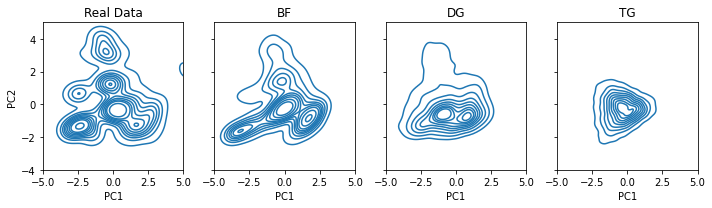

In [38]:
fig, ax = plt.subplots(1,4, figsize=(10,3), sharex=True, sharey=True)
ax[0].set_ylim([-4,5])
ax[0].set_xlim([-5,5])
ax[1].set_ylim([-4,5])
ax[1].set_xlim([-5,5])
ax[2].set_ylim([-4,5])
ax[2].set_xlim([-5,5])
ax[3].set_ylim([-4,5])
ax[3].set_xlim([-5,5])

# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
# ax[0].set_title("Banksformer Generated")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
# ax[1].set_title("Real Data")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
# ax[2].set_title("DG Generated")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="tg"], x="PC1", y="PC2",ax=ax[3])
# ax[3].set_title("TG Generated")
# plt.tight_layout()

sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[0])
ax[0].set_title("Real Data")

sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[1])
ax[1].set_title("BF")

sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
ax[2].set_title("DG")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="tg"], x="PC1", y="PC2",ax=ax[3])
ax[3].set_title("TG")
plt.savefig("figs/seq_pca.png")
plt.tight_layout()

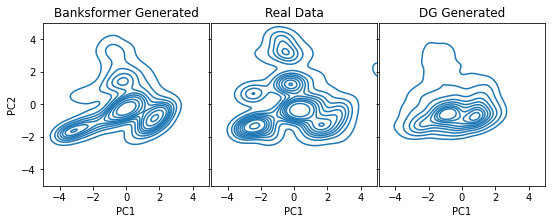

In [46]:
fig, ax = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
ax[0].set_ylim([-5,5])
ax[0].set_xlim([-5,5])
ax[1].set_ylim([-5,5])
ax[1].set_xlim([-5,5])
ax[2].set_ylim([-5,5])
ax[2].set_xlim([-5,5])
# fig.subplots_adjust(hspace=.1) # height spaces
fig.subplots_adjust(wspace=0.01) # width spaces

sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
ax[0].set_title("Banksformer Generated")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
ax[1].set_title("Real Data")
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
ax[2].set_title("DG Generated")
plt.show()
# plt.tight_layout()

# Cash flow

In [75]:
for df in [gen_df, tg_df, fgen_df]:

    df["month"] = df["datetime"].dt.month
    df["day"]   = df["datetime"].dt.day
    df["dow"]  =  df["datetime"].dt.dayofweek
    df["year"]  = df["datetime"].dt.year

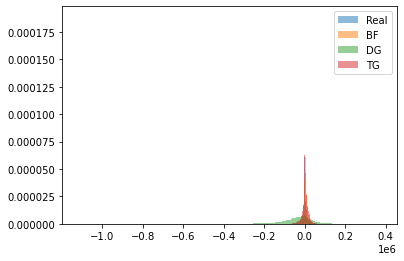

,real,gen,dg,tg,diff_bf,diff_dg,diff_tg
count,185057.000000,71782.000000,2.461300e+04,64709.000000,113275.000000,1.604440e+05,120348.000000
mean,1065.354397,3654.628391,-3.780130e+04,1585.318238,-2589.273993,3.886665e+04,-519.963841
std,12509.136299,11690.148568,8.425977e+04,17071.194344,818.987731,-7.175063e+04,-4562.058045
min,-101550.300000,-80535.840000,-1.123743e+06,-152143.310000,-21014.460000,1.022193e+06,50593.010000
25%,-2266.600000,-1628.915000,-7.459092e+04,-4434.450000,-637.685000,7.232432e+04,2167.850000
50%,1058.100000,2759.640000,-2.735912e+04,105.840000,-1701.540000,2.841722e+04,952.260000
75%,4132.200000,8431.330000,8.058819e+03,10958.280000,-4299.130000,-3.926619e+03,-6826.080000
max,115038.200000,121087.150000,3.802634e+05,82362.750000,-6048.950000,-2.652252e+05,32675.450000


In [56]:
### monthly cash flow by account

# gb = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"], as_index=False)["raw_amount"].sum()

# plt.hist(gb.raw_amount, bins="auto")
# plt.show()

# gb = gen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

# plt.hist(gb.raw_amount, bins="auto")
# plt.show()

# plt.figure(figsize=(12,4))




gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbg = gen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbfg = fgen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbtg = tg_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

plt.hist(gbr.raw_amount, bins="auto", label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins="auto", label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins="auto", label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins="auto", label="TG", density=True, alpha=0.5)


plt.legend()
plt.show()

df = pd.DataFrame.from_dict({"real": gbr.raw_amount.describe(),
                             "gen": gbg.raw_amount.describe(),
                             "dg": gbfg.raw_amount.describe(),
                             "tg": gbtg.raw_amount.describe(),
                            
                            })
df["diff_bf"] = df.real - df.gen
df["diff_dg"] = df.real - df.dg
df["diff_tg"] = df.real - df.tg
df

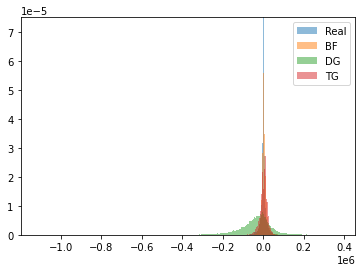

In [57]:
plt.hist(gbr.raw_amount, bins="auto", label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins="auto", label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins="auto", label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins="auto", label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

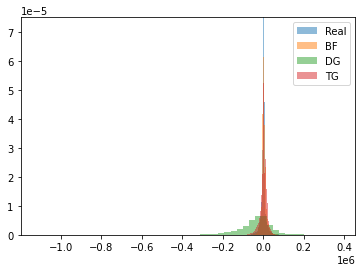

In [59]:
plt.hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins=50, label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins=50, label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins=50, label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

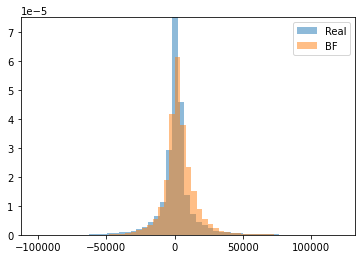

In [60]:


plt.hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins=50, label="BF", density=True, alpha=0.5)
# plt.hist(gbfg.raw_amount, bins=50, label="DG", density=True, alpha=0.5)
# plt.hist(gbtg.raw_amount, bins=50, label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

In [75]:
from scipy.stats import wasserstein_distance

##### fig

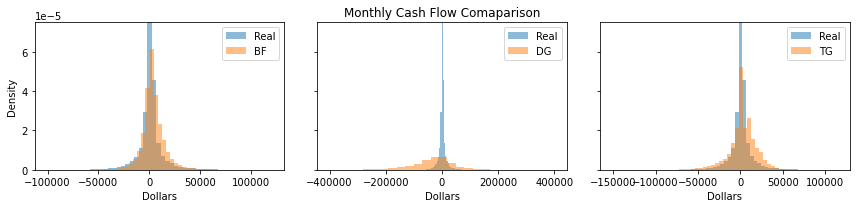

In [155]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       # sharex=True, 
                       sharey=True)

# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])
# ax[3].set_ylim([-5,5])
# ax[3].set_xlim([-5,5])

for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    ax[i].set_ylim([0.0, 0.000075])
    
    if i==1:
        ax[i].set_xlim([-10e5/2.25, 10e5/2.25])
        
    ax[i].legend()
    
    wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    # print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")

ax[0].set_ylabel("Density")

ax[0].set_xlabel("Dollars")
ax[1].set_xlabel("Dollars")
ax[2].set_xlabel("Dollars")
    
# plt.legend()
plt.tight_layout()
plt.savefig("figs/cash_flow_cz.png")
plt.show()

Wasserstein between real and BF is 2738.720419510724
Wasserstein between real and DG is 57800.05021510121
Wasserstein between real and TG is 4980.963992803339


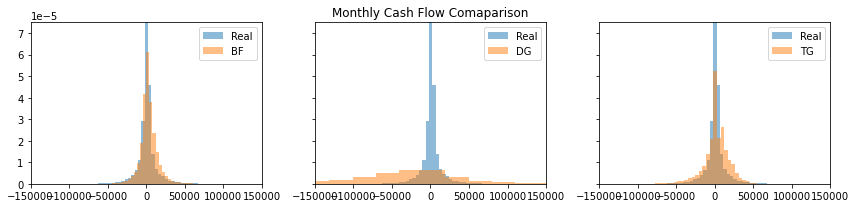

In [82]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       # sharex=True, 
                       sharey=True)

# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])
# ax[3].set_ylim([-5,5])
# ax[3].set_xlim([-5,5])

for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    ax[i].set_ylim([0.0, 0.000075])
    ax[i].set_xlim([-10e4*1.5, 10e4*1.5])
    ax[i].legend()
    
    wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")
    
# plt.legend()
plt.tight_layout()
plt.show()

In [282]:
# for fname in [
#  'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
#  'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
#  'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#     ]:

for fname in [
    'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
 'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
    ]:
    
    # print(fname)
    
    gdf = pd.read_csv("generated_data/" + fname, parse_dates=['datetime'])
    
    
    
    gdf["month"] = gdf["datetime"].dt.month
    gdf["day"]   = gdf["datetime"].dt.day
    gdf["dow"]  =  gdf["datetime"].dt.dayofweek
    gdf["year"]  = gdf["datetime"].dt.year


# gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
    gbg = gdf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

    wd = wasserstein_distance(gbr.raw_amount, gbg.raw_amount)
    print(wd)
    # print("Wasserstein between real is", wd, "\n\n")
    
    

2738.720419510724
4191.260127452959
4775.233584873214
4138.9269155801985
4980.963992803339
57800.05021510121


# New - joint dom, tcode

In [39]:
real_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'column_a', 'account_id', 'date', 'type',
       'operation', 'amount', 'balance', 'k_symbol', 'age', 'tcode',
       'datetime', 'month', 'day', 'dow', 'year', 'td', 'dtme', 'doy',
       'raw_amount', 'days_passed', 'Amount'],
      dtype='object')

In [40]:
fgen_df.columns

Index(['Unnamed: 0', 'unnamed: 0', 'tcode', 'amount', 'balance', 'age', 'dif',
       'account_id', 'date', 'date.1', 'cum_dif', 'days_passed', 'short_tcode',
       'raw_tcode', 'k_symbol', 'operation', 'type', 'datetime', 'raw_amount'],
      dtype='object')

In [41]:
# Creates dataframe with ngram counts.
def create_ngramcount_df(df, n, field):
    gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)[field]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1
            
            
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)
    
            
    return df.reset_index().rename(columns={"index": "ngram"})



In [42]:
for df in [gen_df, fgen_df, tg_df]:
    break
    
    

In [43]:
def set_tcode_day(df):
    df['tcode_day'] = df.tcode + "---" + df.day.astype(str)
    


# End new

In [46]:
os.listdir("generated_data/")

['f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv',
 '.DS_Store',
 'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
 'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
 '.ipynb_checkpoints',
 'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv']

In [47]:
2738
2738
5780

5780

In [48]:
10e6*0.25

2500000.0

# Univariate

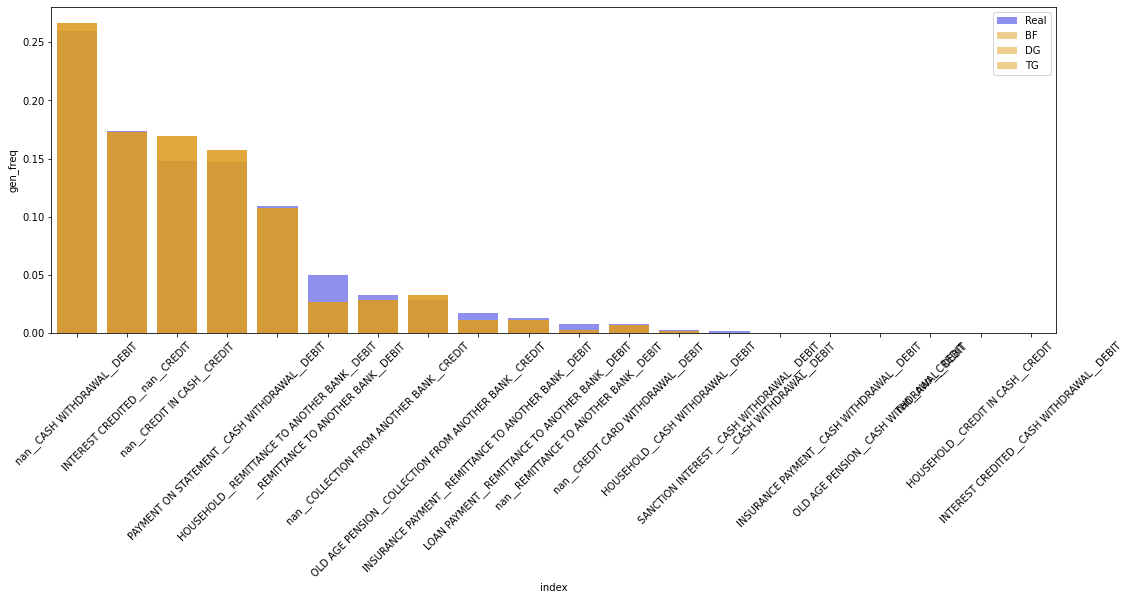

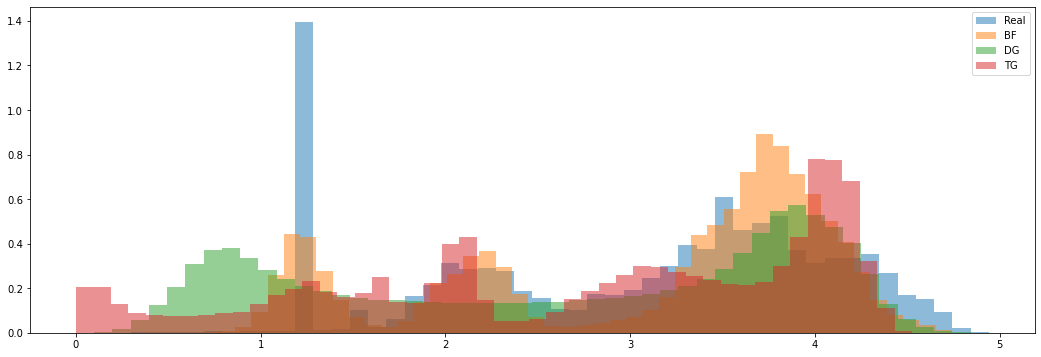

In [49]:
nshow = 20
real_vcs = real_df["tcode"].value_counts()


gen_vcs = gen_df["tcode"].value_counts()

fgen_vcs = fgen_df["tcode"].value_counts()

tg_vcs = tg_df["tcode"].value_counts()

tcode_counts = pd.merge(real_vcs.reset_index(), 
                        gen_vcs.reset_index(), on='index', how="outer", suffixes=("_real", "_gen")).fillna(0)

tcode_counts = pd.merge(tcode_counts.reset_index(), 
                        fgen_vcs.reset_index(), on='index', how="outer", suffixes=("", "_fgen")).fillna(0)
tcode_counts.rename(columns={"tcode":"tcode_fgen"}, inplace=True)

tcode_counts = pd.merge(tcode_counts.drop(columns=['level_0']).reset_index(), 
                        tg_vcs.reset_index(), on='index', how="outer", suffixes=("", "_tg")).fillna(0)
tcode_counts.rename(columns={"tcode":"tcode_tg"}, inplace=True)




tcode_counts["real_freq"] = tcode_counts["tcode_real"] / sum(tcode_counts["tcode_real"])
tcode_counts["gen_freq"] = tcode_counts["tcode_gen"] / sum(tcode_counts["tcode_gen"])
tcode_counts["fgen_freq"] = tcode_counts["tcode_fgen"] / sum(tcode_counts["tcode_fgen"])
tcode_counts["tg_freq"]   = tcode_counts["tcode_tg"] / sum(tcode_counts["tcode_tg"])


plt.figure(figsize=(18, 6))
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real") 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF")
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="DG")
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="TG")

for item in fig.get_xticklabels():
  item.set_rotation(45)


plt.legend()

plt.show()   


ax, fig = plt.subplots(1,1, figsize=(18, 6))
plt.hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True)
plt.hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
plt.hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
plt.hist(np.log10(tg_df["amount"].abs()+1), bins=50, alpha=0.5, label="TG", density=True)
plt.legend()

plt.show()   

print("\n"*3)

In [50]:
!pwd

/Users/kylenickerson/Desktop/verafin_proj_big/ecmlkdd/code/metrics-final


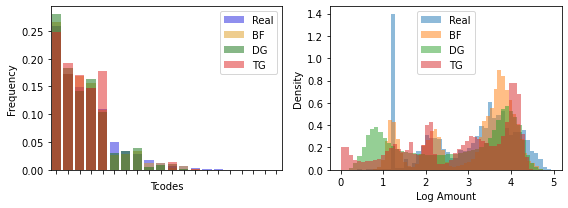

In [51]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])

# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
# ax[0].set_title("Banksformer Generated")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
# ax[1].set_title("Real Data")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
# ax[2].set_title("DG Generated")
# plt.tight_layout()


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF", ax=ax[0])
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="fgen_freq", x="index", color="g", alpha=0.5, label="DG", ax=ax[0])
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="tg_freq", x="index", color="r", alpha=0.5, label="TG", ax=ax[0])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("Frequency")
# for item in fig.get_xticklabels():
#     item.set_rotation(90)
#     item.set_text("")

 


# ax, fig = plt.subplots(1,1, figsize=(18, 6))
ax[1].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1].hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
ax[1].hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
ax[1].hist(np.log10(tg_df["amount"].abs()+1), bins=50, alpha=0.5, label="TG", density=True)
ax[1].set_xlabel("Log Amount")
ax[1].set_ylabel("Density")

plt.legend()
plt.tight_layout()
plt.show()  

### Figure

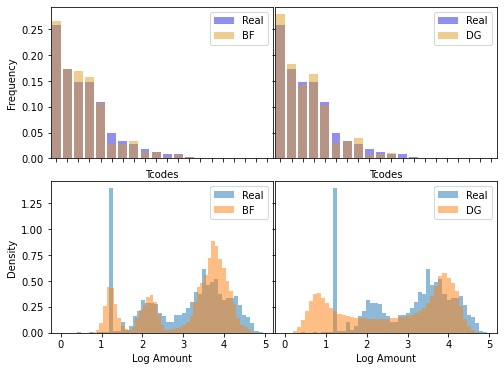

In [52]:
fig, ax = plt.subplots(2,2, figsize=(8,6), sharey="row", sharex="row")
# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])

# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="gen"], x="PC1", y="PC2",ax=ax[0])
# ax[0].set_title("Banksformer Generated")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[1])
# ax[1].set_title("Real Data")
# sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="fgen"], x="PC1", y="PC2",ax=ax[2])
# ax[2].set_title("DG Generated")
# plt.tight_layout()
fig.subplots_adjust(hspace=.15) # height spaces
fig.subplots_adjust(wspace=.01) # width spaces

fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,0]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF", ax=ax[0,0])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("Frequency")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,1]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="fgen_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,1])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")

# for item in fig.get_xticklabels():
#     item.set_rotation(90)
#     item.set_text("")

 


# ax, fig = plt.subplots(1,1, figsize=(18, 6))
ax[1, 0].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 0].hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
ax[1, 0].set_xlabel("Log Amount")
ax[1, 0].set_ylabel("Density")


ax[1, 0].legend()

ax[1, 1].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 1].hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
ax[1, 1].set_xlabel("Log Amount")
# ax[1, 1].set_ylabel("Density")




plt.legend()
# plt.tight_layout()
plt.show()  

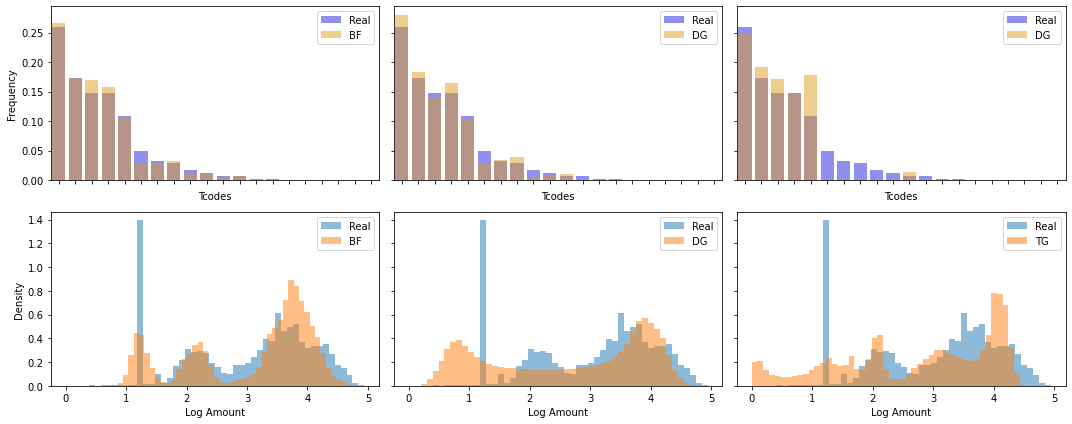

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,6), sharey="row", sharex="row")



fig.subplots_adjust(hspace=.15) # height spaces
fig.subplots_adjust(wspace=.01) # width spaces



###   Top row (tcodes)   ###
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,0]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF", ax=ax[0,0])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("Frequency")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,1]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="fgen_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,1])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,2]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="tg_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,2])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")




# for item in fig.get_xticklabels():
#     item.set_rotation(90)
#     item.set_text("")

 
    
###   Bottom row (amounts)   ###


# ax, fig = plt.subplots(1,1, figsize=(18, 6))
ax[1, 0].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 0].hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
ax[1, 0].set_xlabel("Log Amount")
ax[1, 0].set_ylabel("Density")


ax[1, 0].legend()

ax[1, 1].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 1].hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
ax[1, 1].set_xlabel("Log Amount")
# ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()

ax[1, 2].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 2].hist(np.log10(tg_df["amount"].abs()+1), bins=50, alpha=0.5, label="TG", density=True)
ax[1, 2].set_xlabel("Log Amount")
ax[1, 2].legend()


plt.legend()
plt.tight_layout()
plt.show()  

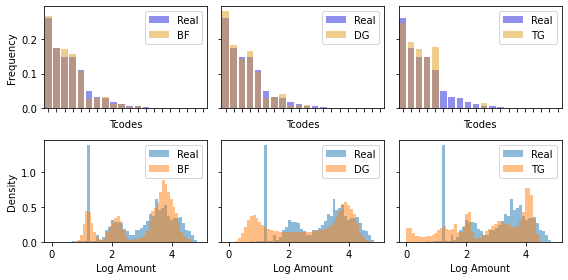

In [54]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharey="row", sharex="row")



fig.subplots_adjust(hspace=.15) # height spaces
fig.subplots_adjust(wspace=.01) # width spaces



###   Top row (tcodes)   ###
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,0]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF", ax=ax[0,0])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("Frequency")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,1]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="fgen_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,1])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,2]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="tg_freq", x="index", color="orange", alpha=0.5, label="TG", ax=ax[0,2])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")




# for item in fig.get_xticklabels():
#     item.set_rotation(90)
#     item.set_text("")

 
    
###   Bottom row (amounts)   ###


# ax, fig = plt.subplots(1,1, figsize=(18, 6))
ax[1, 0].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 0].hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
ax[1, 0].set_xlabel("Log Amount")
ax[1, 0].set_ylabel("Density")
ax[1, 0].legend()

ax[1, 1].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 1].hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
ax[1, 1].set_xlabel("Log Amount")
ax[1, 1].legend()
# ax[1, 1].set_ylabel("Density")


ax[1, 2].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 2].hist(np.log10(tg_df["amount"].abs()+1), bins=50, alpha=0.5, label="TG", density=True)
ax[1, 2].set_xlabel("Log Amount")
ax[1, 2].legend()


plt.tight_layout()
plt.savefig("figs/cz_uv_both.png")
plt.show()  

In [55]:
import matplotlib.ticker as mtick

NameError: name 'gbg' is not defined

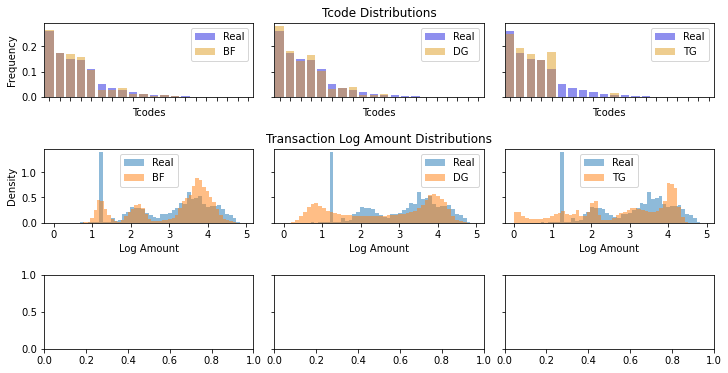

In [56]:
fig, ax = plt.subplots(3,3, figsize=(12,6), sharey="row", sharex="row")



fig.subplots_adjust(hspace=.7) # height spaces
fig.subplots_adjust(wspace=.1) # width spaces



###   Top row (tcodes)   ###
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,0]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF", ax=ax[0,0])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("Frequency")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,1]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="fgen_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,1])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,2]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="tg_freq", x="index", color="orange", alpha=0.5, label="TG", ax=ax[0,2])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")


ax[0, 1].set_title("Tcode Distributions")


# for item in fig.get_xticklabels():
#     item.set_rotation(90)
#     item.set_text("")

 
    
###   Mid row (amounts)   ###


# ax, fig = plt.subplots(1,1, figsize=(18, 6))
ax[1, 0].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 0].hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
ax[1, 0].set_xlabel("Log Amount")
ax[1, 0].set_ylabel("Density")
ax[1, 0].legend()

ax[1, 1].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 1].hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
ax[1, 1].set_xlabel("Log Amount")
ax[1, 1].legend()
# ax[1, 1].set_ylabel("Density")


ax[1, 2].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[1, 2].hist(np.log10(tg_df["amount"].abs()+1), bins=50, alpha=0.5, label="TG", density=True)
ax[1, 2].set_xlabel("Log Amount")
ax[1, 2].legend()

ax[1, 1].set_title("Transaction Log Amount Distributions")


#### Bottom Row (cash flow)  ####


for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[2, i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[2, i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    ax[2, i].set_ylim([0.0, 0.000075])
    ax[2, i].set_xlim([-10e4*1.5, 10e4*1.5])
    ax[2, i].set_xlabel("Dollars")
    ax[2, i].legend()
    
    # wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    # print("Wasserstein between real and", lbl, "is", wd)
    
ax[2, 1].set_title("Monthly Cash Flow Distributions")


ax[2, 1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

ax[2, 1].xaxis.set_major_locator(plt.MaxNLocator(3))

# plt.tight_layout()
plt.savefig("figs/cz_uv_both.png")
plt.show()  

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(7,2), sharey="row", sharex="row", squeeze=False)



fig.subplots_adjust(hspace=.15) # height spaces
fig.subplots_adjust(wspace=.01) # width spaces



###   Top row (tcodes)   ###
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,0]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="gen_freq", x="index", color="orange", alpha=0.5, label="BF", ax=ax[0,0])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("Frequency")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,1]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="fgen_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,1])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")


fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="real_freq", x="index", color="b", alpha=0.5, label="Real", ax=ax[0,2]) 
fig = sns.barplot(data = tcode_counts.iloc[:nshow], y="tg_freq", x="index", color="orange", alpha=0.5, label="DG", ax=ax[0,2])
fig.set_xticklabels(["" for _ in range(len(tcode_counts.iloc[:nshow]))])
fig.legend()
fig.set_xlabel("Tcodes")
fig.set_ylabel("")

plt.tight_layout()
plt.savefig("figs/cz_uv_tcodes.png")
plt.show()

# for item in fig.get_xticklabels():
#     item.set_rotation(90)
#     item.set_text("")

 
fig, ax = plt.subplots(1,3, figsize=(7,2), sharey="row", sharex="row", squeeze=False)

###   Bottom row (amounts)   ###


# ax, fig = plt.subplots(1,1, figsize=(18, 6))
ax[0, 0].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[0, 0].hist(np.log10(gen_df["amount"].abs()+1), bins=50, alpha=0.5, label="BF", density=True)
ax[0, 0].set_xlabel("Log Amount")
ax[0, 0].set_ylabel("Density")
ax[0, 0].legend()

ax[0, 1].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[0, 1].hist(np.log10(fgen_df["amount"].abs()+1), bins=50, alpha=0.5, label="DG", density=True)
ax[0, 1].set_xlabel("Log Amount")
ax[0, 1].legend()
# a0[1, 1].set_ylabel("Density")


ax[0, 2].hist(np.log10(real_df["amount"]+1), bins=50, alpha=0.5, label="Real", density=True )
ax[0, 2].hist(np.log10(tg_df["amount"].abs()+1), bins=50, alpha=0.5, label="TG", density=True)
ax[0, 2].set_xlabel("Log Amount")
ax[0, 2].legend()


plt.tight_layout()
plt.savefig("figs/cz_uv_logamt.png")
plt.show()  

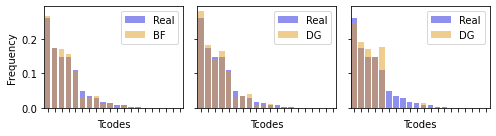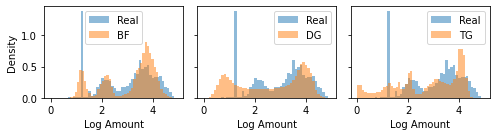

# Joint

### Figure

In [ ]:
fig, ax = plt.subplots(2,3 , figsize=(9,6), sharey=True, sharex="col")


for i, (ii, tcode, count_r, count_g, count_f, real_freq, gen_freq, fgen_freq) in tcode_counts.iterrows():
    print(tcode, i)
    plt.figure(figsize=(18,6))
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    
    tcode= tcode.split("--")[0]

    ax[0, i].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[0, i].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[0, i].legend()
#     ax[0, i].set_title(tcode)
#     ax[0, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[1, i].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[1, i].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[1, i].legend()
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')


    if i > 1: break
      



ax[1, 0].set_xlabel("Log Amount")
ax[1, 1].set_xlabel("Log Amount")
ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")

plt.tight_layout()

plt.show()

In [57]:
tcode_counts

,level_0,index,tcode_real,tcode_gen,tcode_fgen,tcode_tg,real_freq,gen_freq,fgen_freq,tg_freq
0,0.0,nan__CASH WITHDRAWAL__DEBIT,274059.0,106767.0,266606.0,98995.0,0.259447,0.266917,0.280205,0.247487
1,1.0,INTEREST CREDITED__nan__CREDIT,183114.0,69294.0,174319.0,76696.0,0.173351,0.173235,0.183211,0.191740
2,2.0,nan__CREDIT IN CASH__CREDIT,156743.0,67901.0,134649.0,68211.0,0.148386,0.169753,0.141517,0.170527
3,3.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,155832.0,62817.0,155934.0,58886.0,0.147523,0.157043,0.163888,0.147215
4,4.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,115254.0,43058.0,98814.0,71077.0,0.109109,0.107645,0.103854,0.177693
...,...,...,...,...,...,...,...,...,...,...
61,0.0,PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BA...,0.0,0.0,0.0,36.0,0.000000,0.000000,0.000000,0.000090
62,0.0,INTEREST CREDITED__nan__DEBIT,0.0,0.0,0.0,28.0,0.000000,0.000000,0.000000,0.000070
63,0.0,INTEREST CREDITED__CREDIT CARD WITHDRAWAL__DEBIT,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000005
64,0.0,LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__CREDIT,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000003


###### new fig

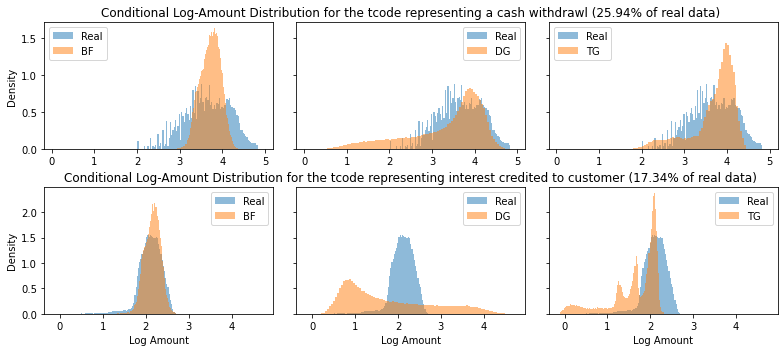

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [94]:
fig, ax = plt.subplots(2,3 , figsize=(11,5), sharey='row', sharex="row")

    # "Day of the Month frequencies for the tcode representing interest credited to the customer",
# interest credited to the customer
titles = [
    "Conditional Log-Amount Distribution for the tcode representing a cash withdrawl",
    # "Conditional Log-Amount Distribution for the tcode representing an interest payment"
    "Conditional Log-Amount Distribution for the tcode representing interest credited to customer"
]


for i, (ii, tcode, count_r, count_g, count_f, count_t, real_freq, gen_freq, fgen_freq, tg_freq) in tcode_counts.iterrows():
    # print(tcode, i)
    plt.figure(figsize=(18,6))
    
    
    percent_of_data = len(real_df[real_df["tcode"]==tcode])/len(real_df)*100
    
    
    title = f"{titles[i]} ({percent_of_data:.2f}% of real data)"
    # title = f"Amount distribution of real transaction with tcode = {tcode} ({percent_of_data:.2f}% of real data)"
    # print(title)
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    vals_t = np.log10(tg_df[tg_df["tcode"]==tcode]["amount"]+1)
    
    # tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
    
    
#     ai, x i].set_title(tcode)
#     ai, x i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
    
    
    ax[i, 2].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 2].hist(vals_t, bins=100, label="TG", alpha=0.5, density=True)
    ax[i, 2].legend()
    
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')



    ax[i,1].set_title(title)


    

    if i > 0: break
    # if i > 1: break
      



ax[1, 0].set_xlabel("Log Amount")
ax[1, 1].set_xlabel("Log Amount")
ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")

# ax[0,1].set_title()

# plt.tight_layout()
fig.tight_layout(h_pad=0.5, w_pad=2)

plt.show()

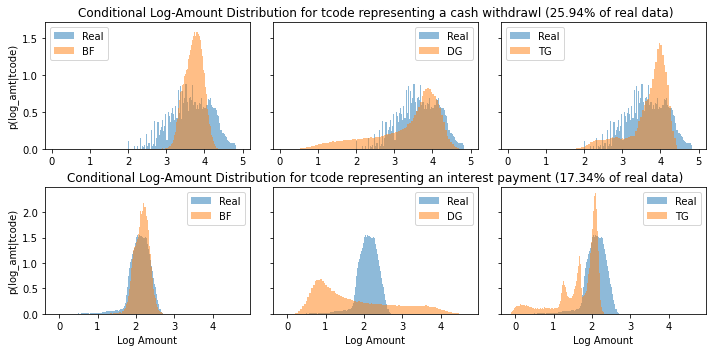

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [72]:
fig, ax = plt.subplots(2,3 , figsize=(10,5), sharey='row', sharex="row")



titles = [
    "Conditional Log-Amount Distribution for tcode representing a cash withdrawl",
    "Conditional Log-Amount Distribution for tcode representing an interest payment"
]


for i, (ii, tcode, count_r, count_g, count_f, count_t, real_freq, gen_freq, fgen_freq, tg_freq) in tcode_counts.iterrows():
    # print(tcode, i)
    plt.figure(figsize=(18,6))
    
    
    
    percent_of_data = len(real_df[real_df["tcode"]==tcode])/len(real_df)*100
    
    
    title = f"{titles[i]} ({percent_of_data:.2f}% of real data)"
    # title = f"Amount distribution of real transaction with tcode = {tcode} ({percent_of_data:.2f}% of real data)"
    # print(title)
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    vals_t = np.log10(tg_df[tg_df["tcode"]==tcode]["amount"]+1)
    
    # tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
    
    
#     ai, x i].set_title(tcode)
#     ai, x i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
    
    
    ax[i, 2].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 2].hist(vals_t, bins=100, label="TG", alpha=0.5, density=True)
    ax[i, 2].legend()
    
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    ax[i,1].set_title(title)


    

    if i > 0: break
    # if i > 1: break
      



ax[1, 0].set_xlabel("Log Amount")
ax[1, 1].set_xlabel("Log Amount")
ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("p(log_amt|tcode)")
ax[1, 0].set_ylabel("p(log_amt|tcode)")

# ax[0,1].set_title()

# plt.tight_layout()
fig.tight_layout(h_pad=0.5, w_pad=2)

plt.show()

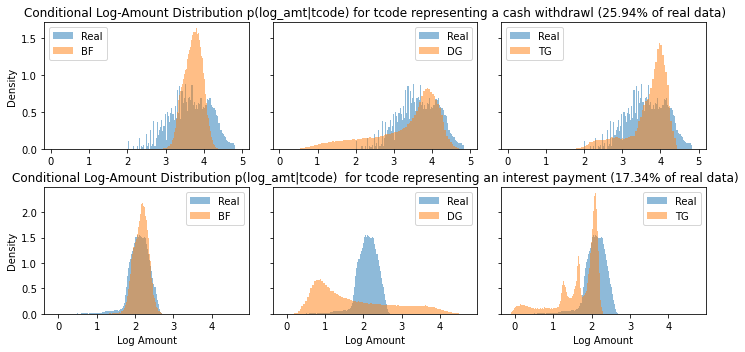

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [71]:
fig, ax = plt.subplots(2,3 , figsize=(10,5), sharey='row', sharex="row")



titles = [
    "Conditional Log-Amount Distribution p(log_amt|tcode) for tcode representing a cash withdrawl",
    "Conditional Log-Amount Distribution p(log_amt|tcode)  for tcode representing an interest payment"
]


for i, (ii, tcode, count_r, count_g, count_f, count_t, real_freq, gen_freq, fgen_freq, tg_freq) in tcode_counts.iterrows():
    # print(tcode, i)
    plt.figure(figsize=(18,6))
    
    
    
    percent_of_data = len(real_df[real_df["tcode"]==tcode])/len(real_df)*100
    
    
    title = f"{titles[i]} ({percent_of_data:.2f}% of real data)"
    # title = f"Amount distribution of real transaction with tcode = {tcode} ({percent_of_data:.2f}% of real data)"
    # print(title)
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    vals_t = np.log10(tg_df[tg_df["tcode"]==tcode]["amount"]+1)
    
    # tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
    
    
#     ai, x i].set_title(tcode)
#     ai, x i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
    
    
    ax[i, 2].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 2].hist(vals_t, bins=100, label="TG", alpha=0.5, density=True)
    ax[i, 2].legend()
    
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    ax[i,1].set_title(title)


    

    if i > 0: break
    # if i > 1: break
      



ax[1, 0].set_xlabel("Log Amount")
ax[1, 1].set_xlabel("Log Amount")
ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")

# ax[0,1].set_title()

# plt.tight_layout()
fig.tight_layout(h_pad=0.5, w_pad=2)

plt.show()

In [ ]:
"for the tcode representing a cash withdrawl"
"for the tcode representing an interest payment"

In [ ]:
"Conditional Log-Amount Distribution for tcode representing a cash withdrawl"
"Conditional Log-Amount Distribution for tcode representing an interest payment"

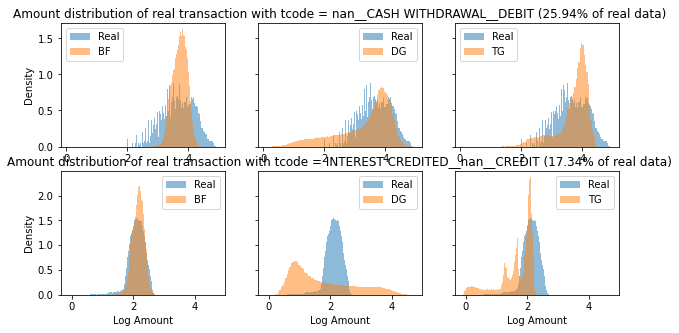

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [66]:
fig, ax = plt.subplots(2,3 , figsize=(10,5), sharey='row', sharex="row")


for i, (ii, tcode, count_r, count_g, count_f, count_t, real_freq, gen_freq, fgen_freq, tg_freq) in tcode_counts.iterrows():
    # print(tcode, i)
    plt.figure(figsize=(18,6))
    
    
    percent_of_data = len(real_df[real_df["tcode"]==tcode])/len(real_df)*100
    
    title = f"Amount distribution of real transaction with tcode = {tcode} ({percent_of_data:.2f}% of real data)"
    # print(title)
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    vals_t = np.log10(tg_df[tg_df["tcode"]==tcode]["amount"]+1)
    
    # tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
    
    
#     ai, x i].set_title(tcode)
#     ai, x i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
    
    
    ax[i, 2].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 2].hist(vals_t, bins=100, label="TG", alpha=0.5, density=True)
    ax[i, 2].legend()
    
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    ax[i,1].set_title(title)


    

    if i > 0: break
    # if i > 1: break
      



ax[1, 0].set_xlabel("Log Amount")
ax[1, 1].set_xlabel("Log Amount")
ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")

# ax[0,1].set_title()

# plt.tight_layout()

plt.show()

nan__CASH WITHDRAWAL__DEBIT 0
INTEREST CREDITED__nan__CREDIT 1


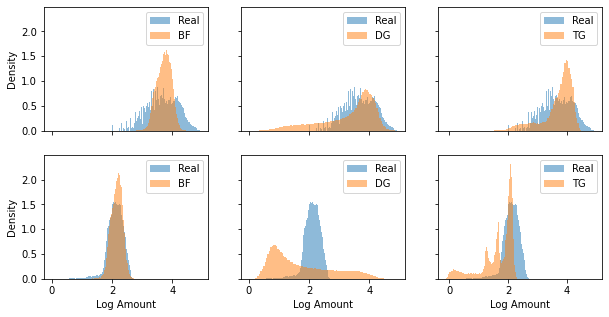

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [131]:
fig, ax = plt.subplots(2,3 , figsize=(10,5), sharey=True, sharex="col")


for i, (ii, tcode, count_r, count_g, count_f, count_t, real_freq, gen_freq, fgen_freq, tg_freq) in tcode_counts.iterrows():
    print(tcode, i)
    plt.figure(figsize=(18,6))
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    vals_t = np.log10(tg_df[tg_df["tcode"]==tcode]["amount"]+1)
    
    # tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
    
    
#     ai, x i].set_title(tcode)
#     ai, x i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
    
    
    ax[i, 2].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 2].hist(vals_t, bins=100, label="TG", alpha=0.5, density=True)
    ax[i, 2].legend()
    
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')


    if i > 0: break
    # if i > 1: break
      



ax[1, 0].set_xlabel("Log Amount")
ax[1, 1].set_xlabel("Log Amount")
ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")

plt.tight_layout()

plt.show()

cash_db_nan 0
interest_cr 1
cash_cr 2


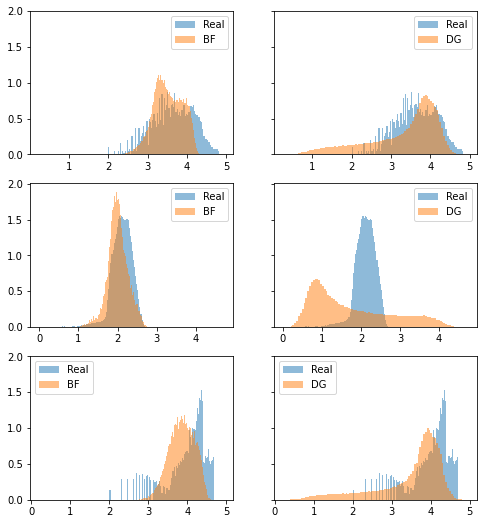

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [80]:
fig, ax = plt.subplots(3,2 , figsize=(8,9), sharey=True, sharex="row")


for i, (ii, tcode, count_r, count_g, count_f, real_freq, gen_freq, fgen_freq) in tcode_counts.iterrows():
    print(tcode, i)
    plt.figure(figsize=(18,6))
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    
    tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
#     ax[0, i].set_title(tcode)
#     ax[0, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')


    if i > 1: break
      



# ax[1, 0].set_xlabel("Log Amount")
# ax[1, 1].set_xlabel("Log Amount")
# ax[1, 2].set_xlabel("Log Amount")

# ax[0, 0].set_ylabel("Density")
# ax[1, 0].set_ylabel("Density")

plt.tight_layout()

plt.show()

cash_db_nan 0
interest_cr 1
cash_cr 2


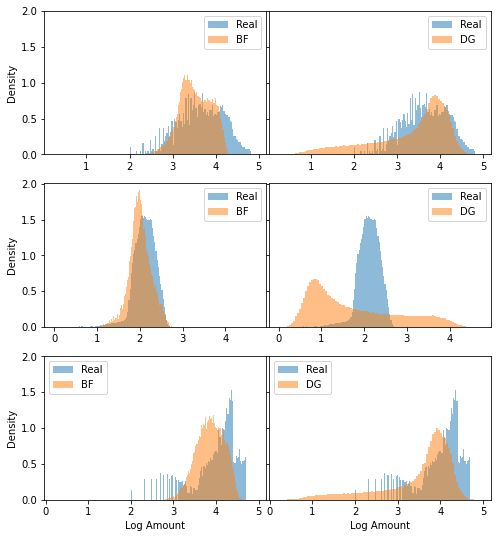

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [85]:
fig, ax = plt.subplots(3,2 , figsize=(8,9), sharey=True, sharex="row")


for i, (ii, tcode, count_r, count_g, count_f, real_freq, gen_freq, fgen_freq) in tcode_counts.iterrows():
    print(tcode, i)
    plt.figure(figsize=(18,6))
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    
    tcode= tcode.split("--")[0]

    ax[i, 0].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=100, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
#     ax[0, i].set_title(tcode)
    ax[0, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=100, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=100, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')


    if i > 1: break
      



ax[2,0].set_xlabel("Log Amount")
ax[2, 1].set_xlabel("Log Amount")
# ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")
ax[2, 0].set_ylabel("Density")
# ax[1, 0].set_ylabel("Density")

# plt.tight_layout()
# fig.subplots_adjust(hspace=.1) # height spaces
fig.subplots_adjust(wspace=.01) # width spaces

plt.show()

cash_db_nan 0
interest_cr 1
cash_cr 2


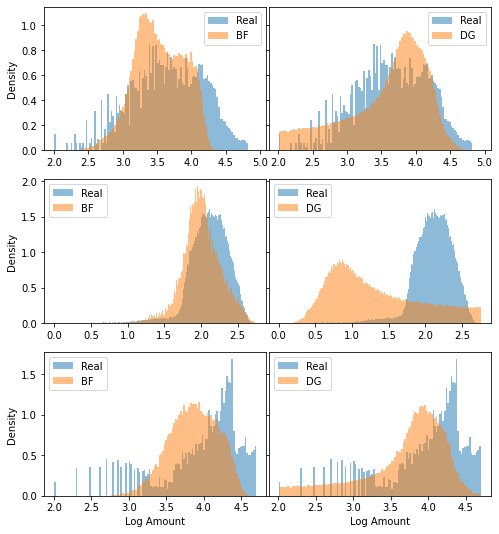

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [103]:

fig, ax = plt.subplots(3,2 , figsize=(8,9), sharey="row", sharex="row")


for i, (ii, tcode, count_r, count_g, count_f, real_freq, gen_freq, fgen_freq) in tcode_counts.iterrows():
    print(tcode, i)
    plt.figure(figsize=(18,6))
    

    vals_r = np.log10(real_df[real_df["tcode"]==tcode]["amount"]+1)
    vals_g = np.log10(gen_df[gen_df["tcode"]==tcode]["amount"]+1)
    vals_f = np.log10(fgen_df[fgen_df["tcode"]==tcode]["amount"]+1)
    
    tcode= tcode.split("--")[0]

    _, bins, _ = ax[i, 0].hist(vals_r, bins="auto", label="Real", alpha=0.5, density=True)
    ax[i, 0].hist(vals_g, bins=bins, label="BF", alpha=0.5, density=True)
    ax[i, 0].legend()
#     ax[0, i].set_title(tcode)
#     ax[i, 0].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')

    
    ax[i, 1].hist(vals_r, bins=bins, label="Real", alpha=0.5, density=True)
    ax[i, 1].hist(vals_f, bins=bins, label="DG", alpha=0.5, density=True)
    ax[i, 1].legend()
    
    
#     ax[1, i].set_title(tcode)
    
#     ax[1, i].set_title(f'{tcode} ({count_r*100 /len(real_df):.3f}% r / {count_g*100/len(gen_df):.3f}% g)')


    if i > 1: break
      



ax[2,0].set_xlabel("Log Amount")
ax[2, 1].set_xlabel("Log Amount")
# ax[1, 2].set_xlabel("Log Amount")

ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")
ax[2, 0].set_ylabel("Density")
# ax[1, 0].set_ylabel("Density")

# plt.tight_layout()
# fig.subplots_adjust(hspace=.1) # height spaces
fig.subplots_adjust(wspace=.01) # width spaces

plt.show()

In [49]:
for i, x in tcode_counts.iterrows(): break

In [50]:

x

level_0                 0
index         cash_db_nan
tcode_real         274059
tcode_gen           71853
tcode_fgen         266606
real_freq        0.259447
gen_freq         0.359265
fgen_freq        0.280205
Name: 0, dtype: object

In [51]:
i

0

# N-grams  

In [134]:
import nltk
from nltk.util import ngrams

In [135]:
def create_ngramcount_df(df, n):
    gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)["tcode"]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1
            
            
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)
    df["freqs"] = df["counts"] / sum(df["counts"])

    df.reset_index(inplace=True)
            
    return df

In [136]:
from scipy.spatial import distance

def jensenshannon_diverg(p,q):
    return distance.jensenshannon(p,q, base=2) ** 2

In [137]:
fgen_df["datetime"] = pd.to_datetime(fgen_df.date)

### Set N  

In [270]:
n = 3
real_ngrams = create_ngramcount_df(real_df, n)
gen_ngrams = create_ngramcount_df(gen_df, n)
fgen_ngrams = create_ngramcount_df(fgen_df, n)
tg_ngrams = create_ngramcount_df(tg_df, n)

In [271]:
combo_df = pd.merge(real_ngrams, gen_ngrams, on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

combo_df =  pd.merge(combo_df, fgen_ngrams, on="index", how="outer").fillna(0.0).rename(columns={
"counts":"counts_fgen", "freqs":"freqs_fgen"
})

combo_df =  pd.merge(combo_df, tg_ngrams, on="index", how="outer").fillna(0.0).rename(columns={
"counts":"counts_tg", "freqs":"freqs_tg", "index":"ngram"
})
# , "index":"ngram"
combo_df

,ngram,counts_real,freqs_real,counts_gen,freqs_gen,counts_fgen,freqs_fgen,counts_tg,freqs_tg
0,"'nan__CASH WITHDRAWAL__DEBIT', 'INTEREST CREDI...",44332.0,0.042329,11230.0,0.028795,34904.0,0.037035,4445.0,0.011397
1,"'nan__CASH WITHDRAWAL__DEBIT', 'PAYMENT ON STA...",40465.0,0.038637,11663.0,0.029905,28014.0,0.029724,2950.0,0.007564
2,"'nan__CASH WITHDRAWAL__DEBIT', 'nan__CASH WITH...",29876.0,0.028526,5727.0,0.014685,50951.0,0.054061,7462.0,0.019133
3,"'INTEREST CREDITED__nan__CREDIT', 'PAYMENT ON ...",25998.0,0.024823,13671.0,0.035054,12664.0,0.013437,3530.0,0.009051
4,'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT'...,21789.0,0.020805,15185.0,0.038936,9797.0,0.010395,2127.0,0.005454
...,...,...,...,...,...,...,...,...,...
5277,"'OLD AGE PENSION__CASH WITHDRAWAL__DEBIT', 'OL...",0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000003
5278,'OLD AGE PENSION__COLLECTION FROM ANOTHER BANK...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000003
5279,"'nan__CASH WITHDRAWAL__DEBIT', 'PAYMENT ON STA...",0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000003
5280,"'nan__REMITTANCE TO ANOTHER BANK__DEBIT', 'nan...",0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000003


In [272]:
jensenshannon_diverg(combo_df["freqs_real"], combo_df["freqs_gen"])

0.06121853387545432

In [273]:
jensenshannon_diverg(combo_df["freqs_real"], combo_df["freqs_fgen"])

0.1899731940381736

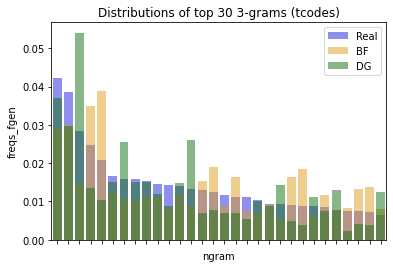

In [274]:

plt.figure(figsize=(6,4))
barplt = sns.barplot(data = combo_df.iloc[:30],x="ngram", y="freqs_real", color="b", alpha=0.5, label="Real")
barplt = sns.barplot(data = combo_df.iloc[:30],x="ngram", y="freqs_gen", color="orange", alpha=0.5, label="BF")
barplt = sns.barplot(data = combo_df.iloc[:30],x="ngram", y="freqs_fgen", color="g", alpha=0.5, label="DG")
# for item in barplt.get_xticklabels():
#     item.set_rotation(70)
    
barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
plt.title("Distributions of top 30 3-grams (tcodes)")    
plt.legend()
plt.show()

### Figure

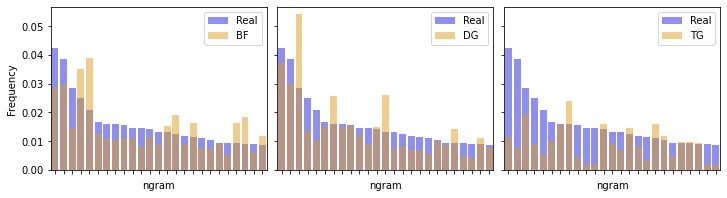

In [275]:

# plt.figure
fig, ax = plt.subplots(1, 3, figsize=(12,3), sharey=True)

barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_real", color="b", alpha=0.5, label="Real", ax=ax[0])
barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_gen", color="orange", alpha=0.5, label="BF", ax=ax[0])


barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
barplt.legend()
barplt.set_ylabel("Frequency")


barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_real", color="b", alpha=0.5, label="Real", ax=ax[1])
barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_fgen", color="orange", alpha=0.5, label="DG", ax=ax[1])

barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
barplt.legend()
barplt.set_ylabel("")



barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_real", color="b", alpha=0.5, label="Real", ax=ax[2])
barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_tg", color="orange", alpha=0.5, label="TG", ax=ax[2])

barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
barplt.legend()
barplt.set_ylabel("")



# plt.title("Distributions of top 30 3-grams (tcodes)")    
plt.legend()
# plt.tight_layout()
fig.subplots_adjust(wspace=.05) 
plt.show()

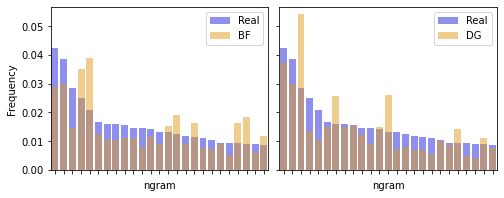

In [276]:

# plt.figure
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)

barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_real", color="b", alpha=0.5, label="Real", ax=ax[0])
barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_gen", color="orange", alpha=0.5, label="BF", ax=ax[0])


barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
barplt.legend()
barplt.set_ylabel("Frequency")


barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_real", color="b", alpha=0.5, label="Real", ax=ax[1])
barplt = sns.barplot(data = combo_df.iloc[:25],x="ngram", y="freqs_fgen", color="orange", alpha=0.5, label="DG", ax=ax[1])

barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
barplt.set_ylabel("")

# plt.title("Distributions of top 30 3-grams (tcodes)")    
plt.legend()
# plt.tight_layout()
fig.subplots_adjust(wspace=.05) 
plt.show()

In [68]:
from scipy.special import rel_entr
from scipy.special import entr

def compute_ngrams(real_df, gen_df, n_vals = range(1, 11), pseudo_counts=0.5, verbose=False, field = "tcode"):

    
    n_tcodes = len(real_df[field].unique())
    
    results = {}

    
    for n in n_vals:

        real_ngrams = create_ngramcount_df(real_df, n)
        gen_ngrams = create_ngramcount_df(gen_df, n)



        combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)


        N_obs_real = real_ngrams["counts"].sum()
        N_obs_gen = real_ngrams["counts"].sum()

        N_possible_ngrams = n_tcodes**n 
        
        j_dist = distance.jaccard(combo_df["counts_real"]>0, combo_df["counts_gen"] > 0)

        combo_df["counts_real"] += pseudo_counts
        combo_df["ps_real"] = combo_df["counts_real"] / (N_obs_real + N_possible_ngrams*pseudo_counts)
        combo_df["counts_gen"] += pseudo_counts
        combo_df["ps_gen"] = combo_df["counts_gen"] / (N_obs_gen + N_possible_ngrams*pseudo_counts)

        combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2



        kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"])) 
        kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))
        
        jsd = (kl_real_M + kl_gen_M)/2
        
        
        n_unobs = N_possible_ngrams - len(combo_df)
        
        entr_r = entr(combo_df["ps_real"]).sum()  # from observed
        p_each_unobs = pseudo_counts / (N_obs_real + N_possible_ngrams*pseudo_counts)
        entr_r += -p_each_unobs*np.log(p_each_unobs)*n_unobs   # from unobserved

        entr_g = entr(combo_df["ps_gen"]).sum()  # from observed
        p_each_unobs = pseudo_counts / (N_obs_gen + N_possible_ngrams*pseudo_counts)
        entr_g += -p_each_unobs*np.log(p_each_unobs)*n_unobs   # from unobserved
             

        if verbose:
            print(f"{n}-grams:\t jsd = {jsd:.3f}\t r-{len(real_ngrams)}\t\t\t ({len(real_ngrams)*100/N_possible_ngrams:.5f}%)\
            \t g-{len(gen_ngrams)} \t ({len(gen_ngrams)*100/N_possible_ngrams:.5f}%)")
            
#         results.append((jsd, entr_r, entr_g))
        results[n] = {"jsd":jsd, "entr_r":entr_r, "entr_g":entr_g,
                     "l1":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=1), 
                      "l2":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=2),
                     "jac": j_dist}
            
    return results



def create_ngramcount_df(df, n, field = "tcode"):
    gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)[field]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1
            
            
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)
    
            
    return df.reset_index().rename(columns={"index": "ngram"})


### Maybe add table like this?

In [69]:
pd.DataFrame.from_dict(compute_ngrams(real_df, gen_df, n_vals = range(1, 5), pseudo_counts=1, verbose=False, field = "tcode"))

,1,2,3,4
jsd,0.170035,0.200642,0.234094,0.249909
entr_r,2.056893,3.890373,5.455137,7.244379
entr_g,0.672812,0.993556,1.332582,2.291324
l1,0.815402,0.845918,0.886829,0.892305
l2,0.320127,0.153464,0.088148,0.047064
jac,0.000000,0.275109,0.538610,0.698239


In [70]:
pd.DataFrame.from_dict(compute_ngrams(real_df, fgen_df, n_vals = range(1, 5), pseudo_counts=1, verbose=False, field = "tcode"))

,1,2,3,4
jsd,0.007996,0.051644,0.124556,0.199044
entr_r,2.056893,3.890373,5.455137,7.244379
entr_g,1.844220,3.384288,4.817066,6.585462
l1,0.116079,0.390344,0.698511,0.909867
l2,0.040486,0.062398,0.054078,0.036587
jac,0.000000,0.267281,0.546660,0.722328


In [72]:
pd.DataFrame.from_dict(compute_ngrams(real_df, gen_df, n_vals = range(1, 5), pseudo_counts=.01, verbose=False, field = "tcode"))

,1,2,3,4
jsd,0.170046,0.200880,0.236512,0.272302
entr_r,2.056860,3.889021,5.425680,6.796817
entr_g,0.672741,0.991437,1.288737,1.577790
l1,0.815414,0.846122,0.890262,0.947787
l2,0.320132,0.153501,0.088489,0.049990
jac,0.000000,0.275109,0.538610,0.698239


In [73]:
pd.DataFrame.from_dict(compute_ngrams(real_df, fgen_df, n_vals = range(1, 5), pseudo_counts=.01, verbose=False, field = "tcode"))

,1,2,3,4
jsd,0.008000,0.051796,0.126587,0.219393
entr_r,2.056860,3.889021,5.425680,6.796817
entr_g,1.844170,3.382679,4.785120,6.103809
l1,0.116080,0.390438,0.701216,0.966440
l2,0.040487,0.062413,0.054287,0.038861
jac,0.000000,0.267281,0.546660,0.722328


In [ ]:
pd.DataFrame.from_dict(compute_ngrams(real_df, gen_df, n_vals = range(1, 5), pseudo_counts=.1, verbose=True, field = "tcode"))

In [ ]:
pd.DataFrame.from_dict(compute_ngrams(real_df, fgen_df, n_vals = range(1, 5), pseudo_counts=.1, verbose=True, field = "tcode"))

In [ ]:
len(tcode_names) 

In [ ]:
len(tcode_names) ** 3

In [ ]:
len(tcode_names) ** 2

In [ ]:
pd.DataFrame.from_dict(compute_ngrams(real_df, gen_df, n_vals = range(1, 5), pseudo_counts=1, verbose=False, field = "tcode"))

In [ ]:
pd.DataFrame.from_dict(compute_ngrams(real_df, fgen_df, n_vals = range(1, 5), pseudo_counts=1, verbose=False, field = "tcode"))

In [ ]:
pd.DataFrame.from_dict(compute_ngrams(real_df, gen_df, n_vals = range(1, 5), pseudo_counts=1e-9, verbose=False, field = "tcode"))

In [ ]:
pd.DataFrame.from_dict(compute_ngrams(real_df, fgen_df, n_vals = range(1, 5), pseudo_counts=1e-9, verbose=False, field = "tcode"))

# Dates

In [219]:
""" PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 14.75%
    __REMITTANCE TO ANOTHER BANK__DEBIT 5.00% """

use_codes = ['PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT', ' __REMITTANCE TO ANOTHER BANK__DEBIT']

### paper fig

Days of real transaction with tcode = INTEREST CREDITED__nan__CREDIT 17.34% of real data
Days of real transaction with tcode = HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT 10.91% of real data


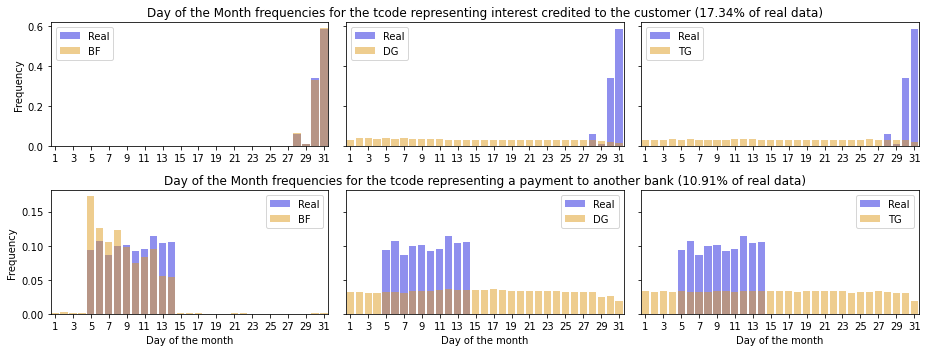

In [88]:
field1 = 'tcode'
field2 = 'day'
plot_sort_by = "counts_real"
plot_n = 32

to_plot = ['INTEREST CREDITED__nan__CREDIT', 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT']
titles = ['Debit from another bank']

titles = [
    # "Day of the Month frequencies for the tcode representing an interest payment",
    "Day of the Month frequencies for the tcode representing interest credited to the customer",
    "Day of the Month frequencies for the tcode representing a payment to another bank",
]

fig, ax = plt.subplots(2,3, figsize = (13, 5), sharey='row', sharex='row')


# f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))


# make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, **barplot_params)



combo_df1 = pd.merge(real_df[field1].value_counts().reset_index(), 
                    gen_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

combo_df2 = pd.merge(fgen_df[field1].value_counts().reset_index(), 
                    tg_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


combo_df_overall = pd.merge(combo_df1, 
                    combo_df2, 
                    on="index", how="outer", suffixes=("XXX", "YYY")
                   ).fillna(0.0).sort_values(by=f"{field1}_real", ascending=False)


f1_opts = to_plot # combo_df_overall["index"]


for row_i, code_1 in enumerate(f1_opts):
    
    combo_df1 = pd.merge(real_df[real_df[field1]==code_1][field2].value_counts().reset_index(), 
                        gen_df[gen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

    combo_df2 = pd.merge(fgen_df[fgen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        tg_df[tg_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


    combo_df = pd.merge(combo_df1, 
                        combo_df2, 
                        on="index", how="outer", suffixes=("XXX", "YYY")).fillna(0.0)
    
    
    percent_of_data = len(real_df[real_df[field1]==code_1])/len(real_df)*100
    print(f"{field2.capitalize()}s of real transaction with {field1} =", 
                  code_1, f"{percent_of_data:.2f}% of real data")
    
    
    for version in ["real", 'gen', 'dg', 'tg']:

        combo_df.rename(columns={f"{field2}_{version}": f"counts_{version}"}, 
                        inplace=True)

        combo_df[f"ps_{version}"] = combo_df[f"counts_{version}"] / np.sum(combo_df[f"counts_{version}"])


    combo_df = combo_df.rename(columns={"index":field2}
                      ).sort_values(by=plot_sort_by, ascending=False
                      ).fillna(0.0)
    
    



    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real", ax=ax[row_i, 0])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_gen", color="orange", alpha=0.5, label="BF", ax=ax[row_i, 0])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[row_i, 1])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_dg", color="orange", alpha=0.5, label="DG", ax=ax[row_i, 1])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[row_i, 2])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_tg", color="orange", alpha=0.5, label="TG", ax=ax[row_i, 2])



    # tick_lbls = False
    # if not tick_lbls:
    #     barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
    # else:
    #     for item in barplt.get_xticklabels():
    #         item.set_rotation(90)

    for i in range(3):

        ax[row_i, i].xaxis.set_major_locator(plt.MaxNLocator(16))
        ax[row_i, i].legend()

        ax[0, i].set_xlabel("")
        ax[-1, i].set_xlabel("Day of the month")
        ax[row_i, i].set_ylabel("")
        
    ax[row_i, 0].set_ylabel("Frequency")
        
  

    percent_of_data = len(real_df[real_df[field1]==code_1])/len(real_df)*100
    title = f"{titles[row_i]} ({percent_of_data:.2f}% of real data)"

    # ax[i,1].set_title(title)
    
    ax[row_i, 1].set_title(title)
    # ax[row_i, 1].set_title(f"Day of the month frequencies for '{code_1}' transactions ({percent_of_data:.2f}% of real data)")    


plt.tight_layout()
plt.show()


    

In [78]:
i

2

In [77]:
titles

['Conditional Log-Amount Distribution for tcode representing a cash withdrawl',
 'Conditional Log-Amount Distribution for tcode representing an interest payment']

Days of real transaction with tcode = nan__CASH WITHDRAWAL__DEBIT 25.94% of real data


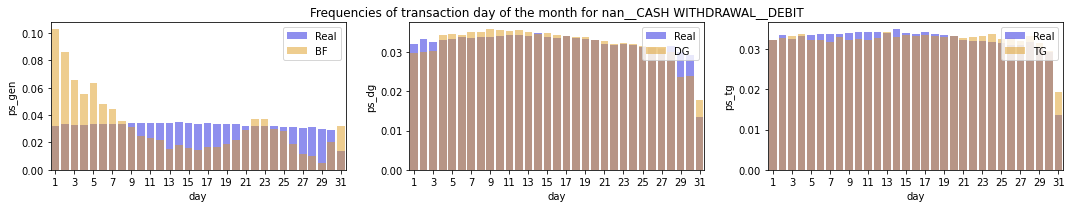

Days of real transaction with tcode = INTEREST CREDITED__nan__CREDIT 17.34% of real data


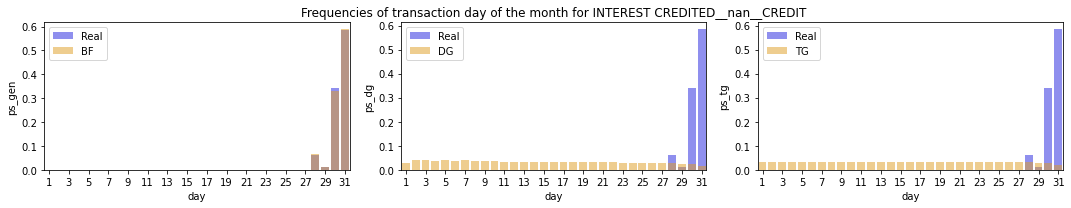

Days of real transaction with tcode = nan__CREDIT IN CASH__CREDIT 14.84% of real data


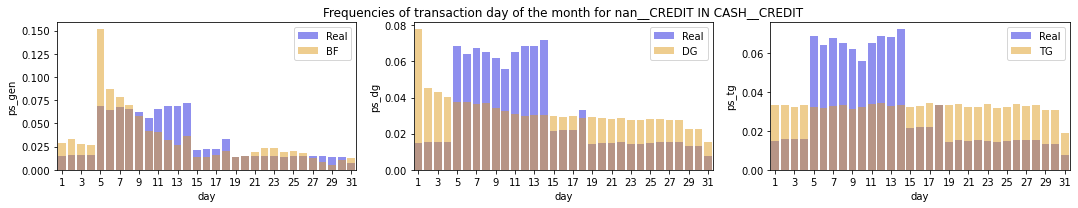

Days of real transaction with tcode = PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 14.75% of real data


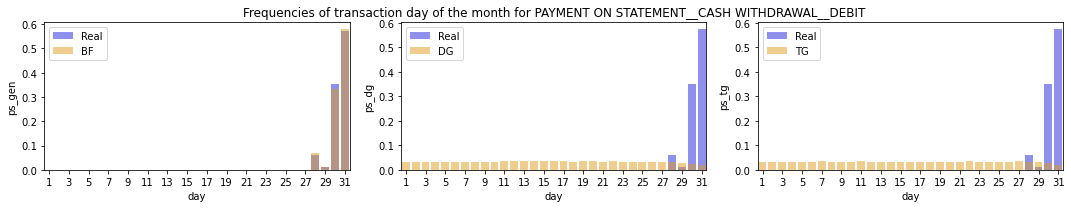

Days of real transaction with tcode = HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT 10.91% of real data


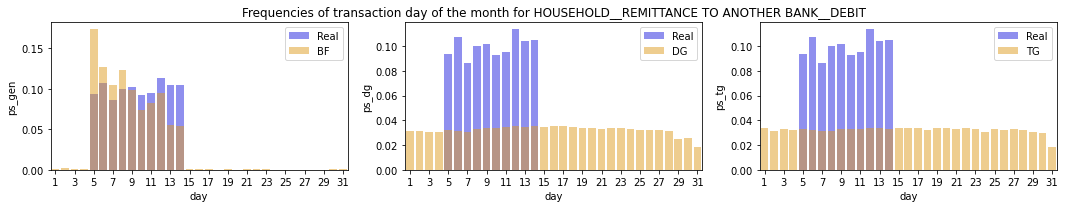

Days of real transaction with tcode =  __REMITTANCE TO ANOTHER BANK__DEBIT 5.00% of real data


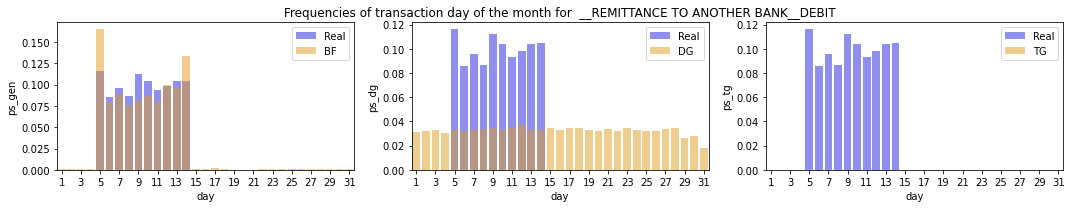

Days of real transaction with tcode = nan__COLLECTION FROM ANOTHER BANK__CREDIT 3.30% of real data


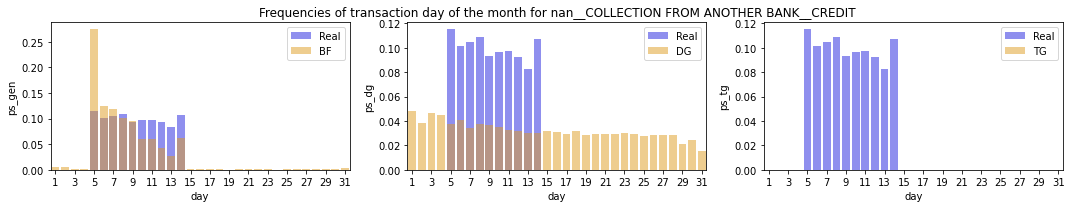

Days of real transaction with tcode = OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT 2.87% of real data


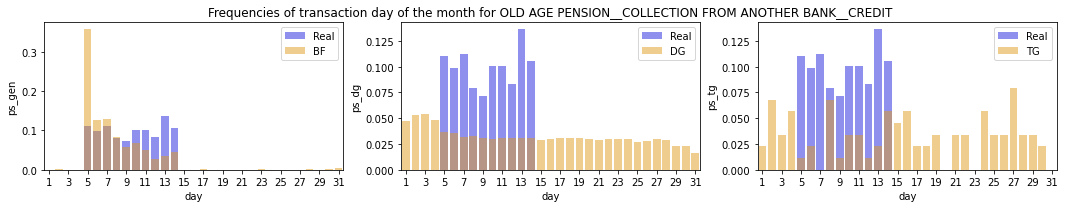

Days of real transaction with tcode = INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT 1.75% of real data


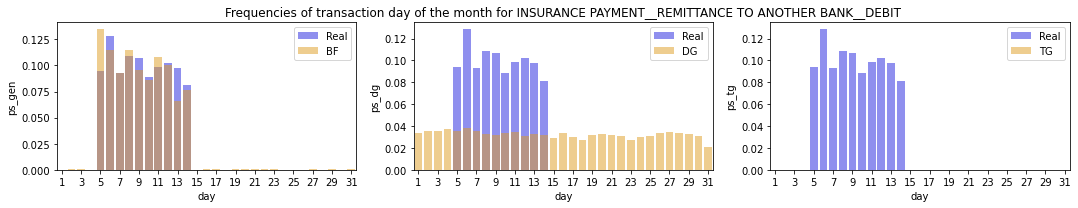

Days of real transaction with tcode = LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT 1.29% of real data


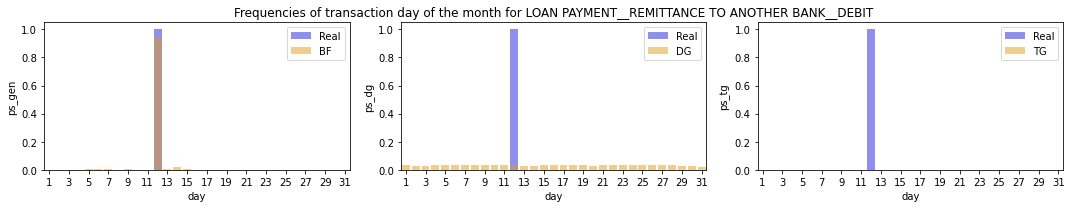

Days of real transaction with tcode = nan__REMITTANCE TO ANOTHER BANK__DEBIT 0.77% of real data


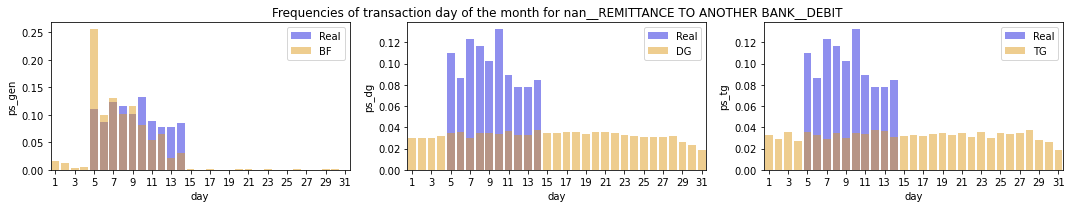

Days of real transaction with tcode = nan__CREDIT CARD WITHDRAWAL__DEBIT 0.76% of real data


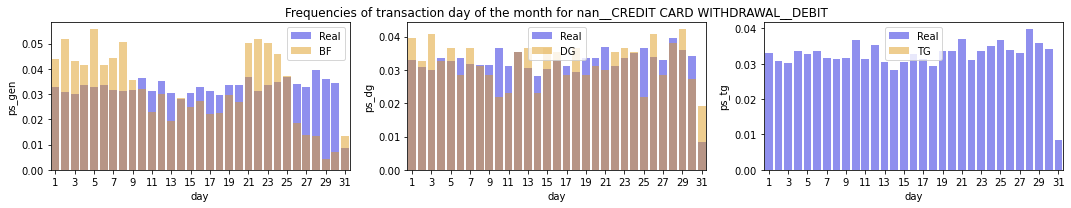

Days of real transaction with tcode = HOUSEHOLD__CASH WITHDRAWAL__DEBIT 0.27% of real data


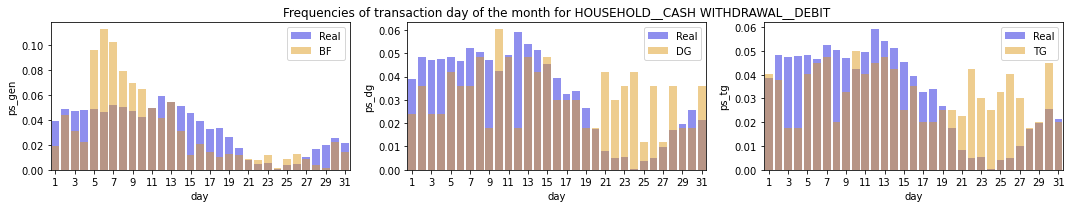

Days of real transaction with tcode = SANCTION INTEREST__CASH WITHDRAWAL__DEBIT 0.15% of real data


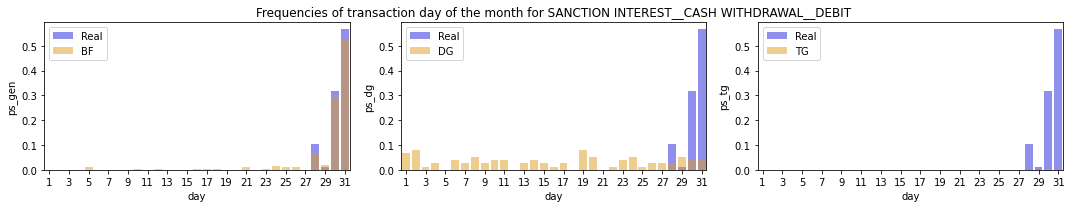

Days of real transaction with tcode =  __CASH WITHDRAWAL__DEBIT 0.06% of real data


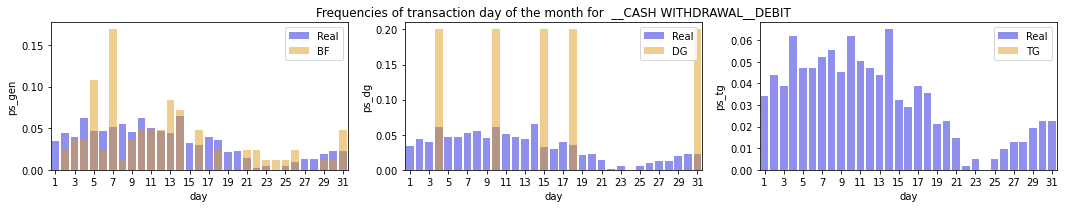

Days of real transaction with tcode = INSURANCE PAYMENT__CASH WITHDRAWAL__DEBIT 0.00% of real data


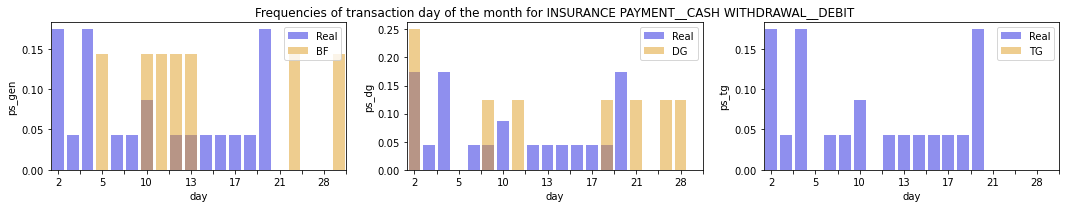

Days of real transaction with tcode = HOUSEHOLD__nan__CREDIT 0.00% of real data


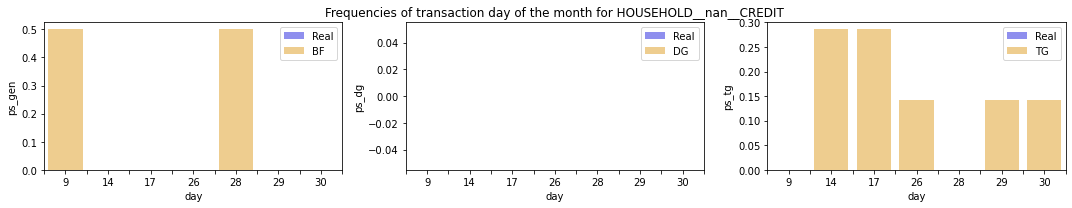

Days of real transaction with tcode =  __CREDIT CARD WITHDRAWAL__DEBIT 0.00% of real data


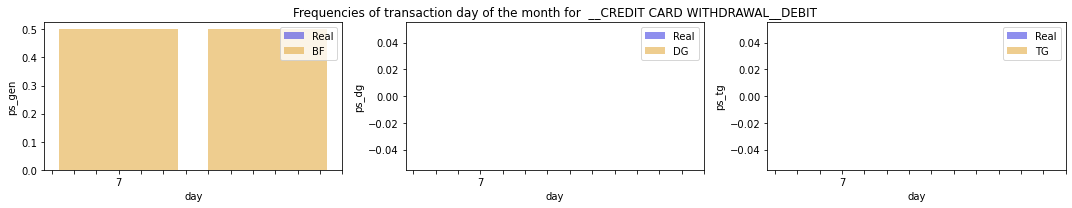

Days of real transaction with tcode = OLD AGE PENSION__CASH WITHDRAWAL__CREDIT 0.00% of real data


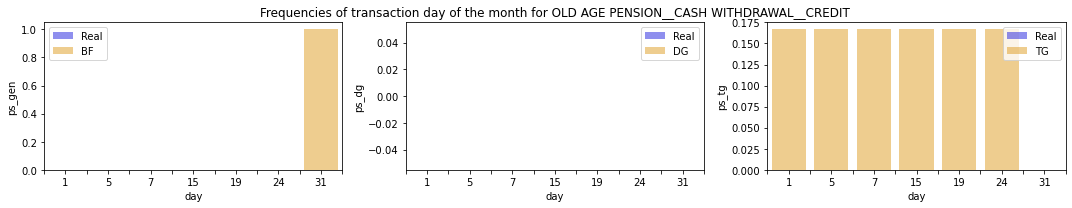

Days of real transaction with tcode = SANCTION INTEREST__COLLECTION FROM ANOTHER BANK__CREDIT 0.00% of real data


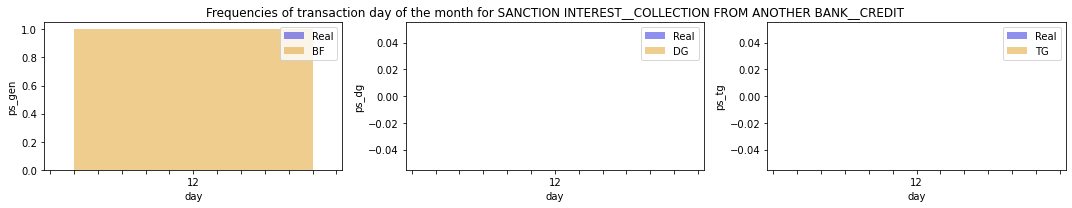

Days of real transaction with tcode = HOUSEHOLD__nan__DEBIT 0.00% of real data


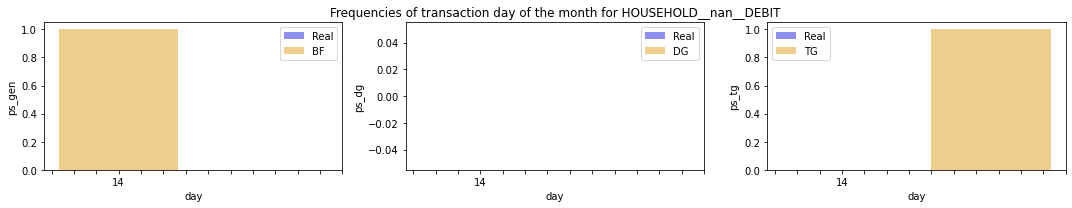

Days of real transaction with tcode = PAYMENT ON STATEMENT__CREDIT CARD WITHDRAWAL__DEBIT 0.00% of real data


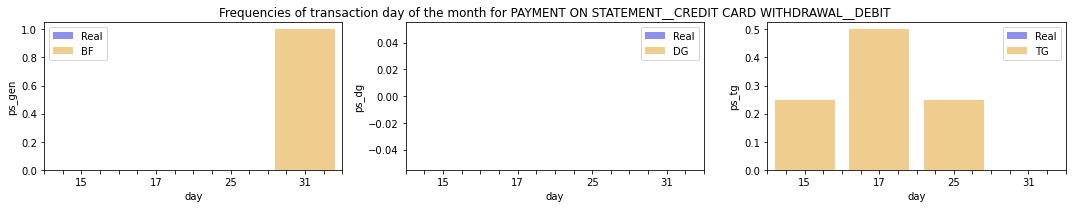

Days of real transaction with tcode = HOUSEHOLD__COLLECTION FROM ANOTHER BANK__DEBIT 0.00% of real data


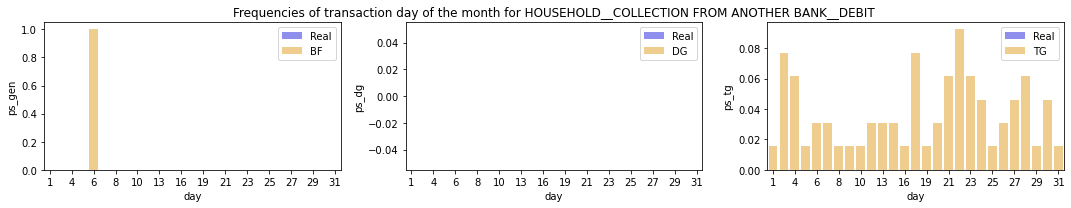

Days of real transaction with tcode = INTEREST CREDITED__CASH WITHDRAWAL__CREDIT 0.00% of real data


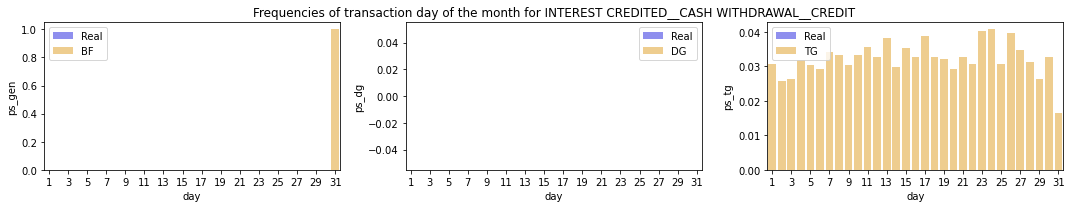

Days of real transaction with tcode = nan__nan__DEBIT 0.00% of real data


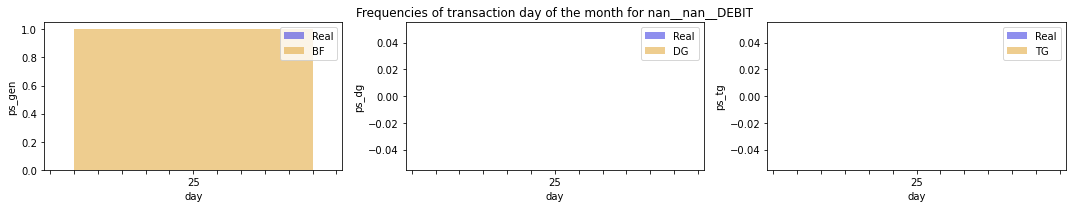

Days of real transaction with tcode = LOAN PAYMENT__COLLECTION FROM ANOTHER BANK__DEBIT 0.00% of real data


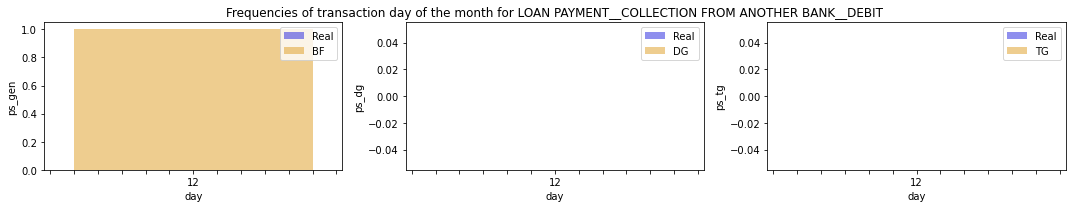

Days of real transaction with tcode = PAYMENT ON STATEMENT__CREDIT IN CASH__DEBIT 0.00% of real data


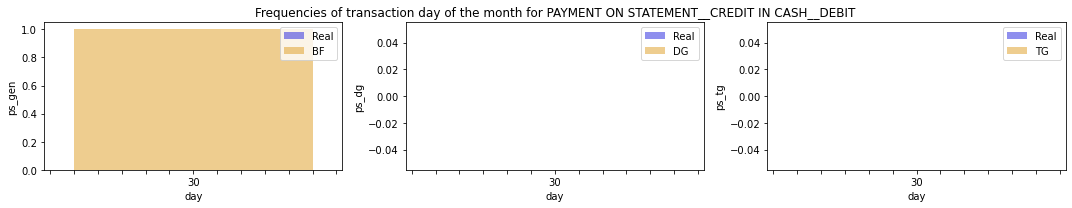

Days of real transaction with tcode = OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__DEBIT 0.00% of real data


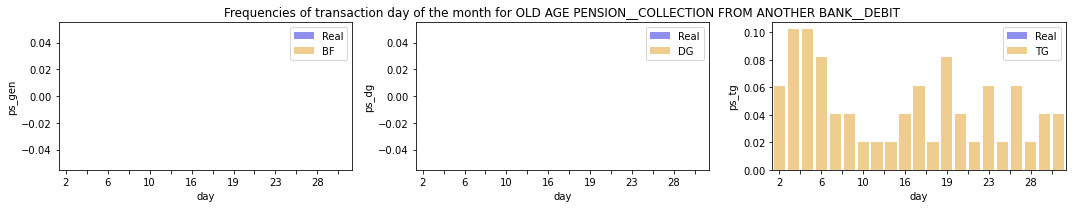

Days of real transaction with tcode = OLD AGE PENSION__CREDIT IN CASH__CREDIT 0.00% of real data


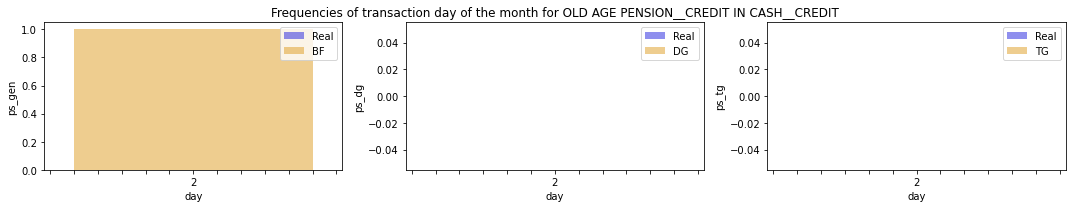

Days of real transaction with tcode = SANCTION INTEREST__CREDIT IN CASH__CREDIT 0.00% of real data


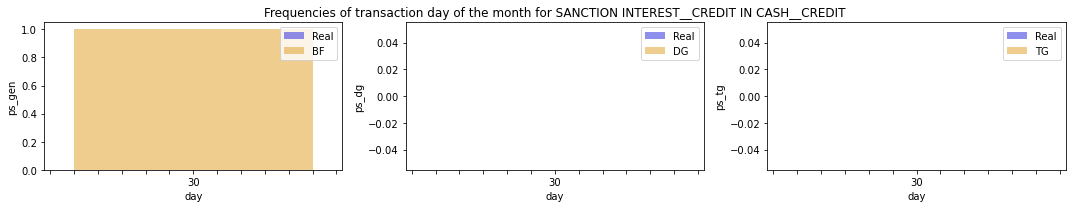

Days of real transaction with tcode = PAYMENT ON STATEMENT__nan__CREDIT 0.00% of real data


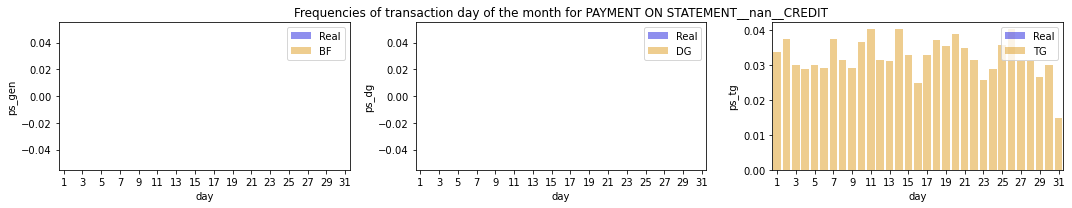

Days of real transaction with tcode = PAYMENT ON STATEMENT__nan__DEBIT 0.00% of real data


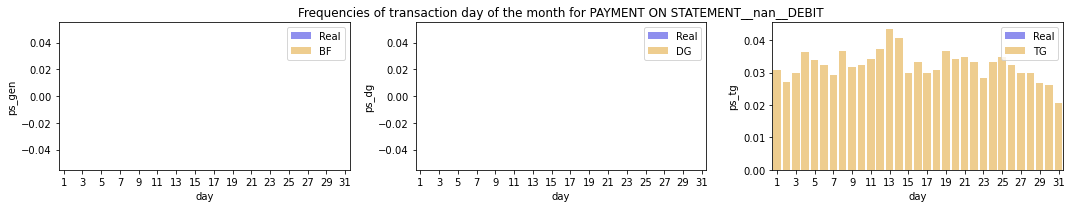

Days of real transaction with tcode = HOUSEHOLD__REMITTANCE TO ANOTHER BANK__CREDIT 0.00% of real data


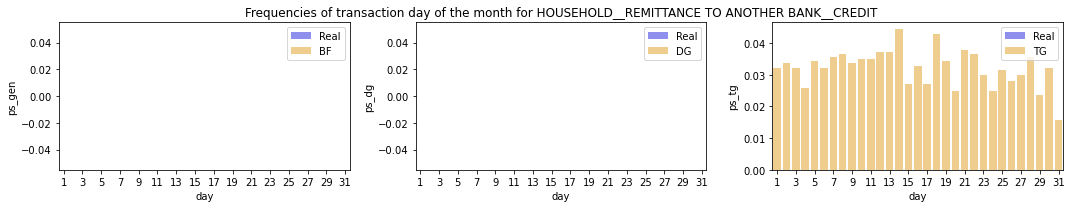

Days of real transaction with tcode = PAYMENT ON STATEMENT__CASH WITHDRAWAL__CREDIT 0.00% of real data


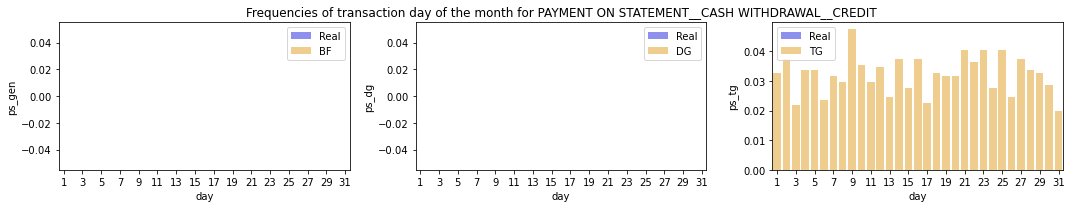

Days of real transaction with tcode = INTEREST CREDITED__REMITTANCE TO ANOTHER BANK__CREDIT 0.00% of real data


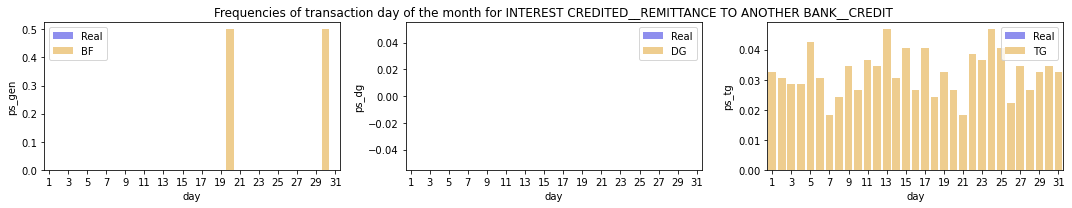

Days of real transaction with tcode = PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BANK__CREDIT 0.00% of real data


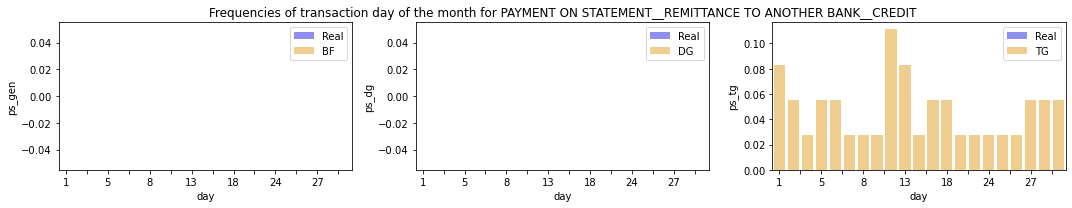

Days of real transaction with tcode = INTEREST CREDITED__nan__DEBIT 0.00% of real data


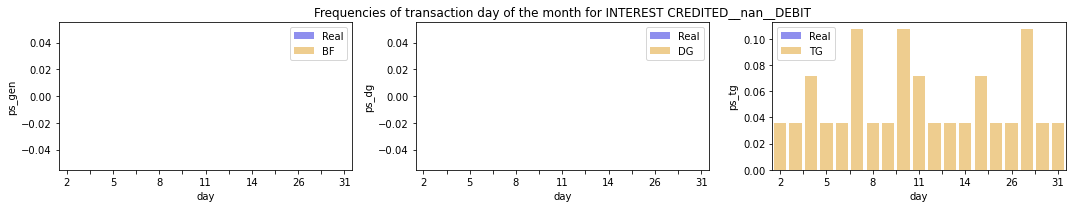

Days of real transaction with tcode = INTEREST CREDITED__CREDIT CARD WITHDRAWAL__DEBIT 0.00% of real data


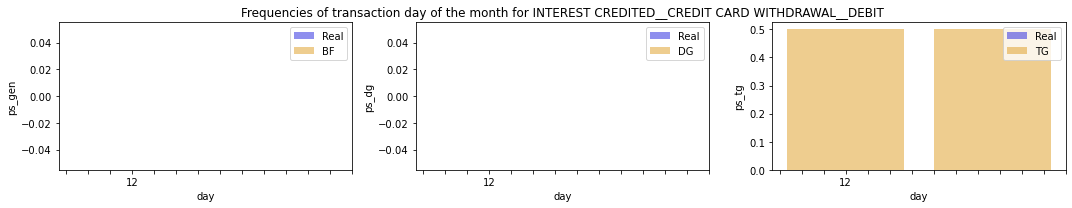

Days of real transaction with tcode = LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__CREDIT 0.00% of real data


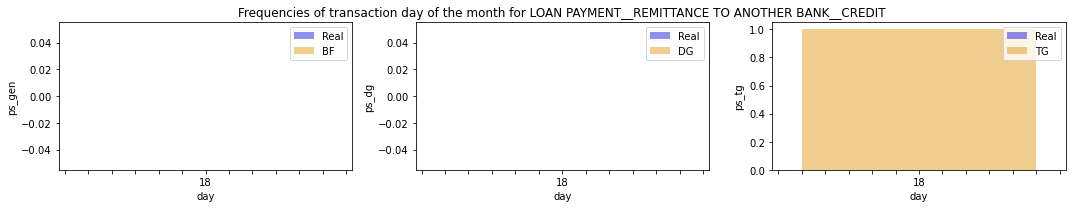

Days of real transaction with tcode = OLD AGE PENSION__nan__CREDIT 0.00% of real data


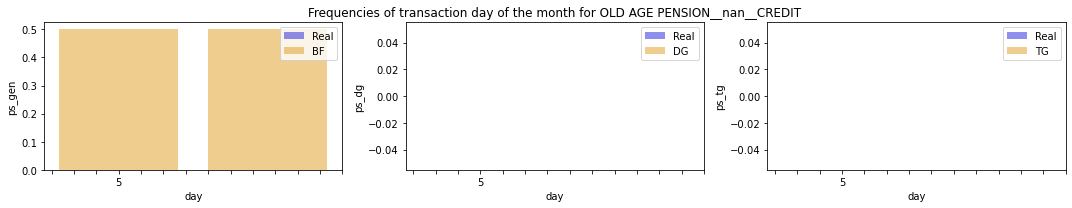

Days of real transaction with tcode = INTEREST CREDITED__COLLECTION FROM ANOTHER BANK__CREDIT 0.00% of real data


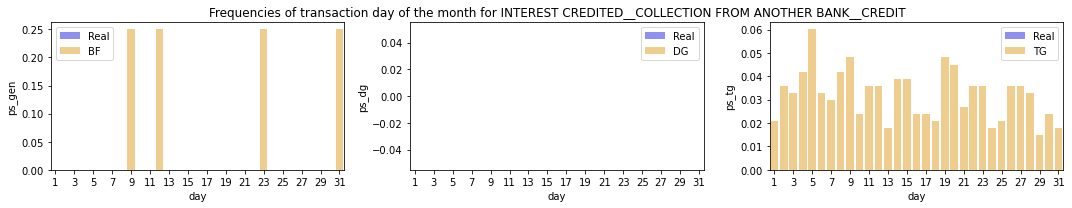

Days of real transaction with tcode = INTEREST CREDITED__CREDIT CARD WITHDRAWAL__CREDIT 0.00% of real data


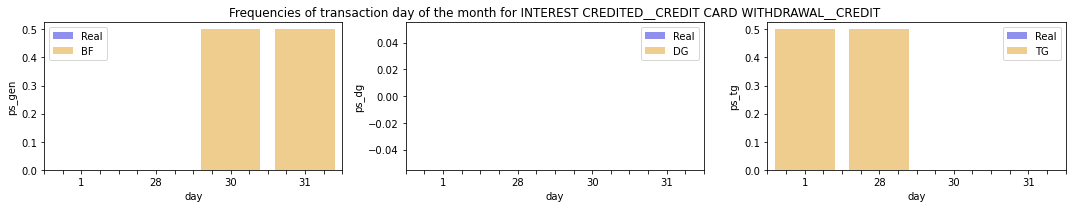

Days of real transaction with tcode = LOAN PAYMENT__COLLECTION FROM ANOTHER BANK__CREDIT 0.00% of real data


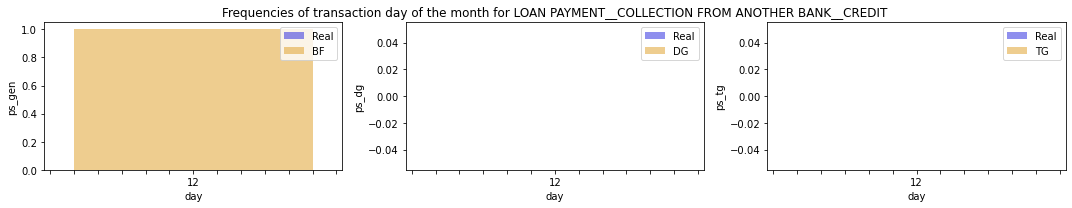

Days of real transaction with tcode = OLD AGE PENSION__CASH WITHDRAWAL__DEBIT 0.00% of real data


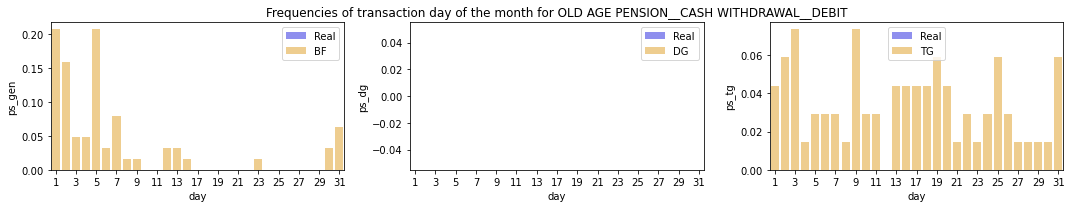

Days of real transaction with tcode = nan__nan__CREDIT 0.00% of real data


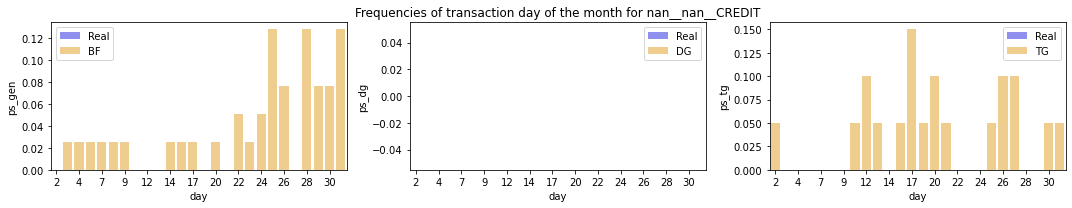

Days of real transaction with tcode = HOUSEHOLD__CREDIT IN CASH__CREDIT 0.00% of real data


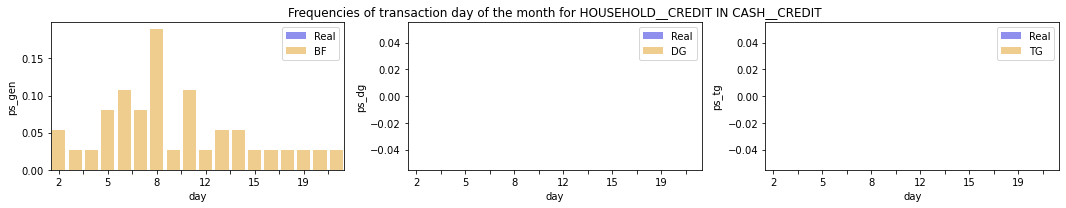

Days of real transaction with tcode = INTEREST CREDITED__CASH WITHDRAWAL__DEBIT 0.00% of real data


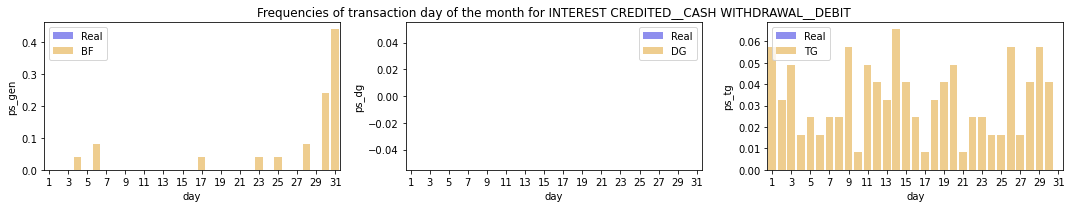

Days of real transaction with tcode =  __CREDIT IN CASH__CREDIT 0.00% of real data


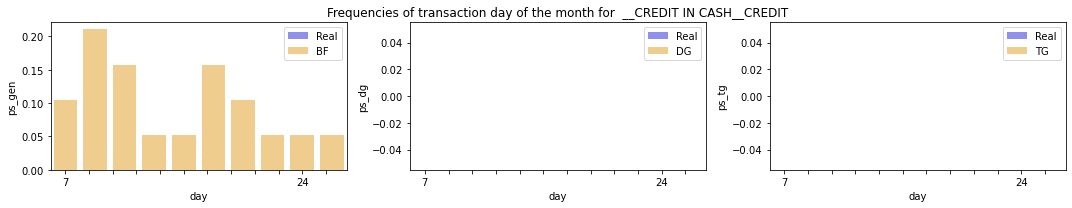

Days of real transaction with tcode = INTEREST CREDITED__CREDIT IN CASH__CREDIT 0.00% of real data


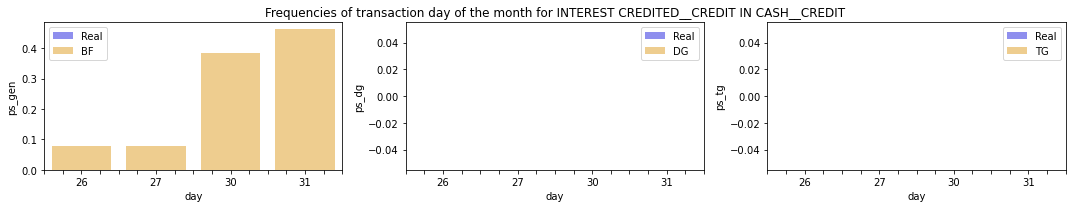

Days of real transaction with tcode = LOAN PAYMENT__CASH WITHDRAWAL__DEBIT 0.00% of real data


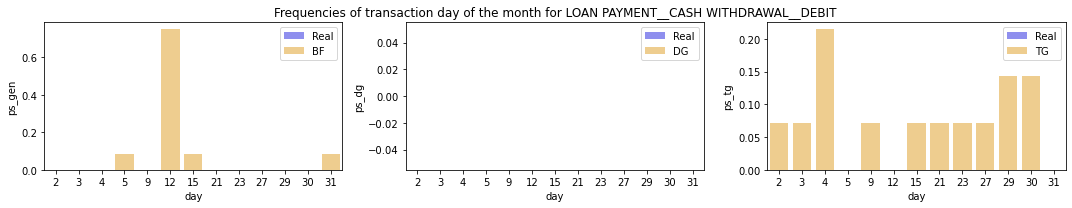

Days of real transaction with tcode = PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BANK__DEBIT 0.00% of real data


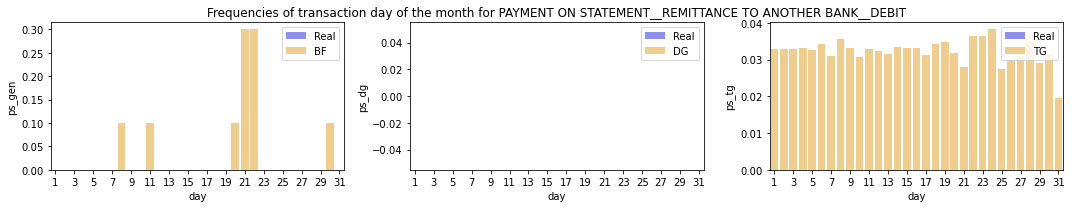

Days of real transaction with tcode = OLD AGE PENSION__REMITTANCE TO ANOTHER BANK__DEBIT 0.00% of real data


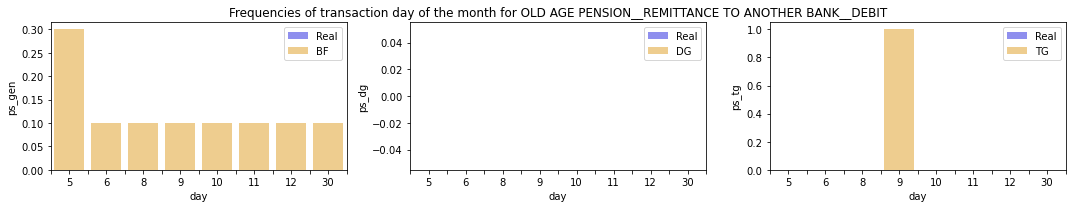

Days of real transaction with tcode = nan__CASH WITHDRAWAL__CREDIT 0.00% of real data


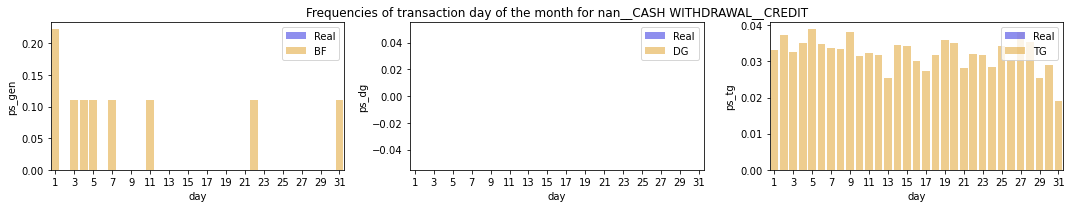

Days of real transaction with tcode = INTEREST CREDITED__REMITTANCE TO ANOTHER BANK__DEBIT 0.00% of real data


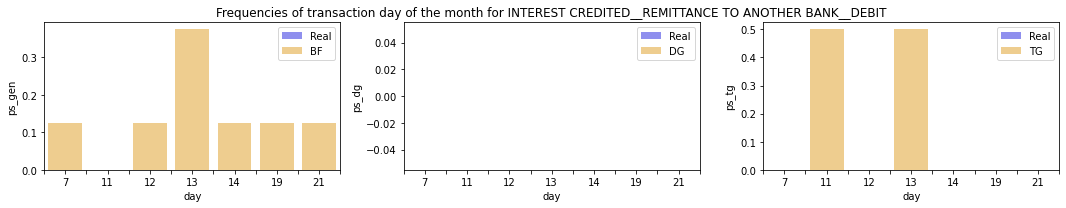

Days of real transaction with tcode = HOUSEHOLD__CREDIT IN CASH__DEBIT 0.00% of real data


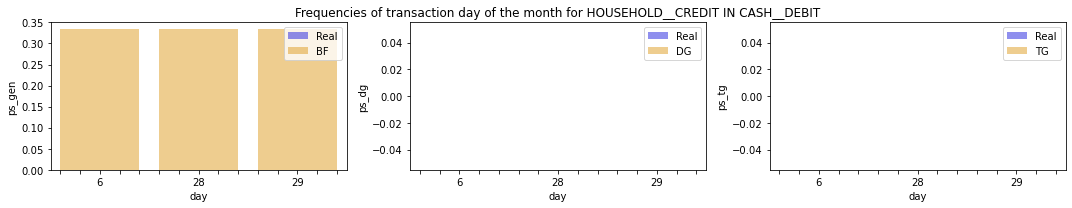

Days of real transaction with tcode = HOUSEHOLD__COLLECTION FROM ANOTHER BANK__CREDIT 0.00% of real data


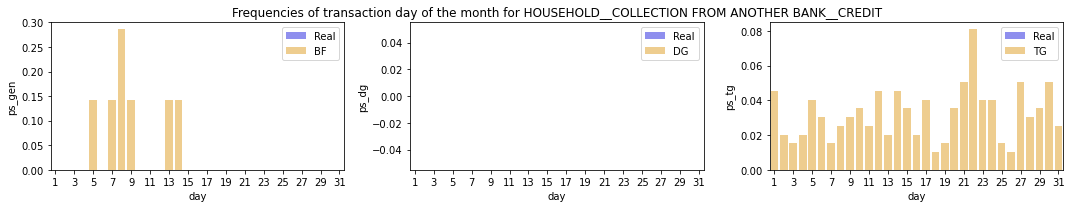

Days of real transaction with tcode = nan__CREDIT IN CASH__DEBIT 0.00% of real data


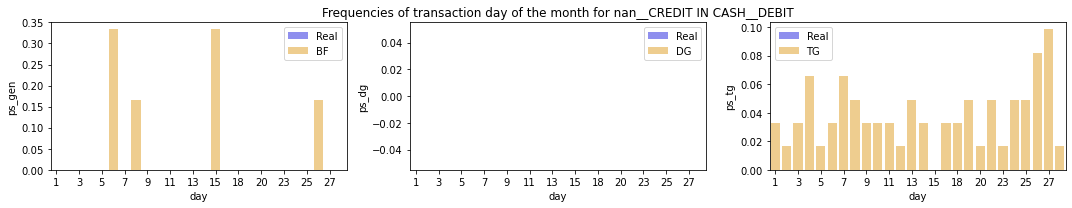

Days of real transaction with tcode = INSURANCE PAYMENT__CREDIT IN CASH__CREDIT 0.00% of real data


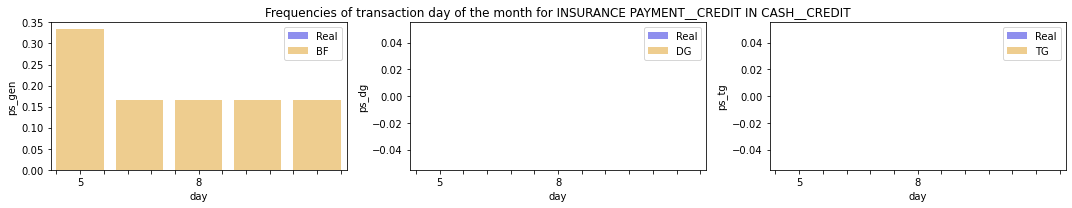

Days of real transaction with tcode = LOAN PAYMENT__CREDIT IN CASH__CREDIT 0.00% of real data


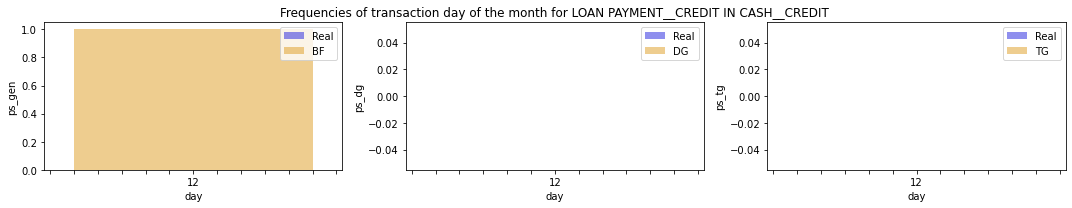

Days of real transaction with tcode =  __COLLECTION FROM ANOTHER BANK__CREDIT 0.00% of real data


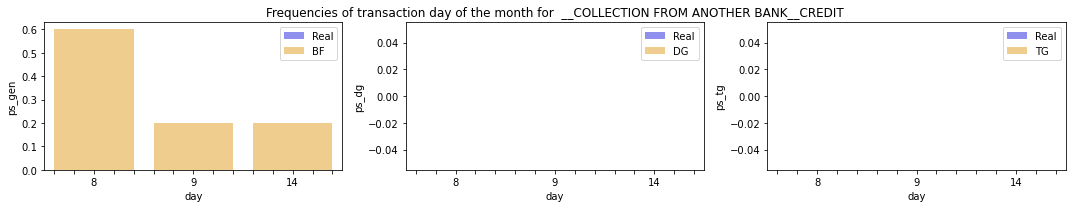

Days of real transaction with tcode = PAYMENT ON STATEMENT__CREDIT IN CASH__CREDIT 0.00% of real data


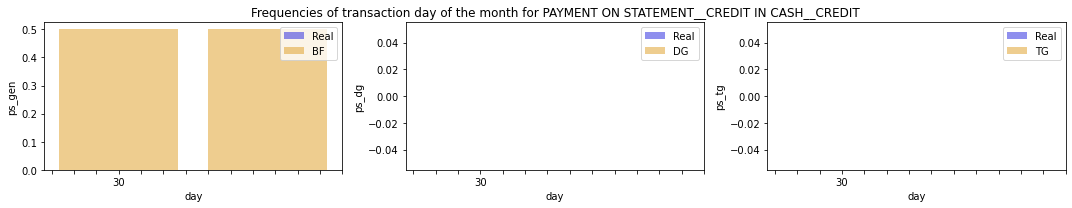

Days of real transaction with tcode = INSURANCE PAYMENT__COLLECTION FROM ANOTHER BANK__CREDIT 0.00% of real data


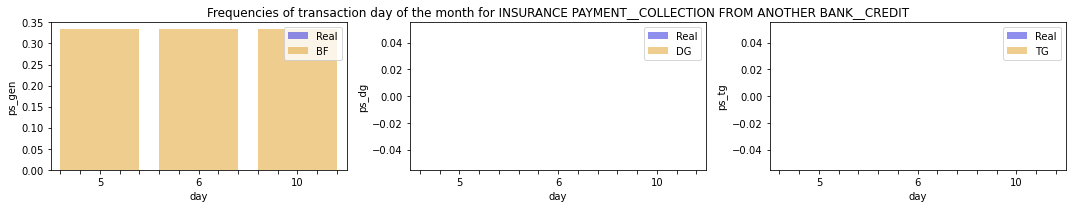

Days of real transaction with tcode =  __CREDIT IN CASH__DEBIT 0.00% of real data


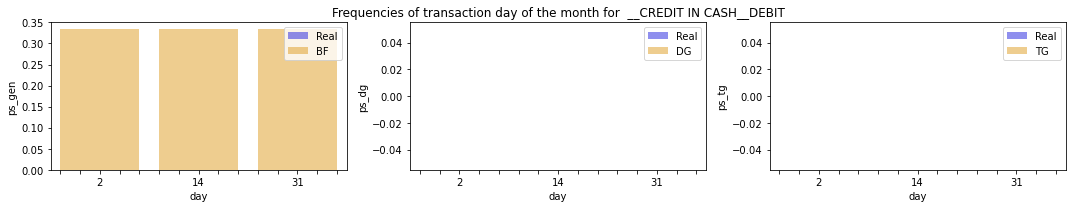

Days of real transaction with tcode = HOUSEHOLD__CREDIT CARD WITHDRAWAL__DEBIT 0.00% of real data


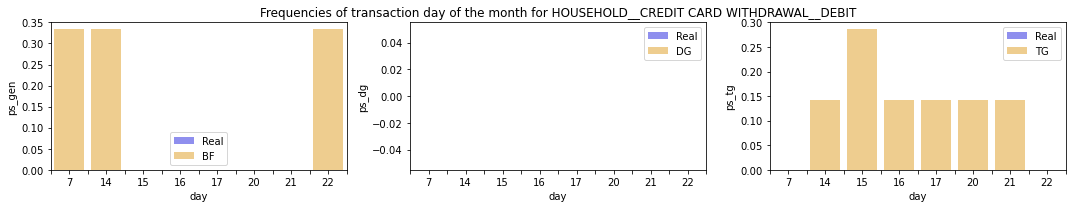

Days of real transaction with tcode = LOAN PAYMENT__CREDIT CARD WITHDRAWAL__DEBIT 0.00% of real data


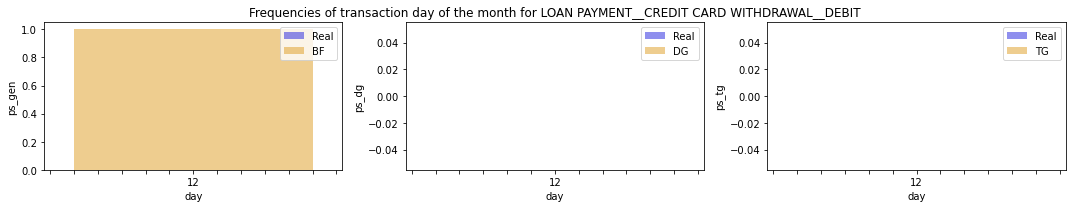

Days of real transaction with tcode = HOUSEHOLD__CASH WITHDRAWAL__CREDIT 0.00% of real data


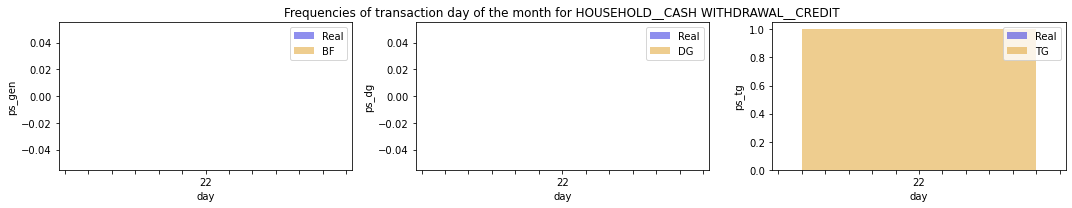

In [256]:
field1 = 'tcode'
field2 = 'day'
plot_sort_by = "counts_real"
plot_n = 32




f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))


# make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, **barplot_params)



combo_df1 = pd.merge(real_df[field1].value_counts().reset_index(), 
                    gen_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

combo_df2 = pd.merge(fgen_df[field1].value_counts().reset_index(), 
                    tg_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


combo_df_overall = pd.merge(combo_df1, 
                    combo_df2, 
                    on="index", how="outer", suffixes=("XXX", "YYY")
                   ).fillna(0.0).sort_values(by=f"{field1}_real", ascending=False)


f1_opts = combo_df_overall["index"]


for code_1 in f1_opts:
    
    combo_df1 = pd.merge(real_df[real_df[field1]==code_1][field2].value_counts().reset_index(), 
                        gen_df[gen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

    combo_df2 = pd.merge(fgen_df[fgen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        tg_df[tg_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


    combo_df = pd.merge(combo_df1, 
                        combo_df2, 
                        on="index", how="outer", suffixes=("XXX", "YYY")).fillna(0.0)
    
    
    
    print(f"{field2.capitalize()}s of real transaction with {field1} =", 
                  code_1, f"{len(real_df[real_df[field1]==code_1])/len(real_df)*100:.2f}% of real data")
    
    
    for version in ["real", 'gen', 'dg', 'tg']:

        combo_df.rename(columns={f"{field2}_{version}": f"counts_{version}"}, 
                        inplace=True)

        combo_df[f"ps_{version}"] = combo_df[f"counts_{version}"] / np.sum(combo_df[f"counts_{version}"])


    combo_df = combo_df.rename(columns={"index":field2}
                      ).sort_values(by=plot_sort_by, ascending=False
                      ).fillna(0.0)
    
    

    fig, ax = plt.subplots(1,3, figsize = (15, 3))

    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real", ax=ax[0])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_gen", color="orange", alpha=0.5, label="BF", ax=ax[0])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[1])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_dg", color="orange", alpha=0.5, label="DG", ax=ax[1])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[2])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_tg", color="orange", alpha=0.5, label="TG", ax=ax[2])



    # tick_lbls = False
    # if not tick_lbls:
    #     barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
    # else:
    #     for item in barplt.get_xticklabels():
    #         item.set_rotation(90)

    for i in range(3):

        ax[i].xaxis.set_major_locator(plt.MaxNLocator(16))
        ax[i].legend()

    # plt.title(f"Frequencies of top {plot_n} {field2}s")    
    ax[1].set_title(f"Frequencies of transaction day of the month for {code_1}")    


    plt.tight_layout()
    plt.show()


    
    

#             make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, ax=ax[0], **barplot_params)
#             ax[0].legend()


#             plot_ecdf(real_df[real_df[field1]==code_1]['raw_amount'], plot_params={"label":"real"}, ax=ax[2])
#             plot_ecdf(gen_df[gen_df[field1]==code_1]['raw_amount'], plot_params={"label":"gen"}, ax=ax[2])

#             ax[2].legend()
#             ax[2].set_title(f"ECDF") # of amounts with {field1} = {code_1}

#             ax[1].hist(real_df[real_df[field1]==code_1]['raw_amount'], label="real", bins = "auto", density=True, alpha=0.5)
#             ax[1].hist(gen_df[gen_df[field1]==code_1]['raw_amount'], label="gen", bins="auto", density=True, alpha=0.5)

#             ax[1].legend()
#             ax[1].set_title(f"Hist of transaction amounts with \n {field1} = {code_1}")

### new

Days of real transaction with tcode = nan__CASH WITHDRAWAL__DEBIT 25.94% of real data
Days of real transaction with tcode = INTEREST CREDITED__nan__CREDIT 17.34% of real data
Days of real transaction with tcode = nan__CREDIT IN CASH__CREDIT 14.84% of real data
Days of real transaction with tcode = PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 14.75% of real data


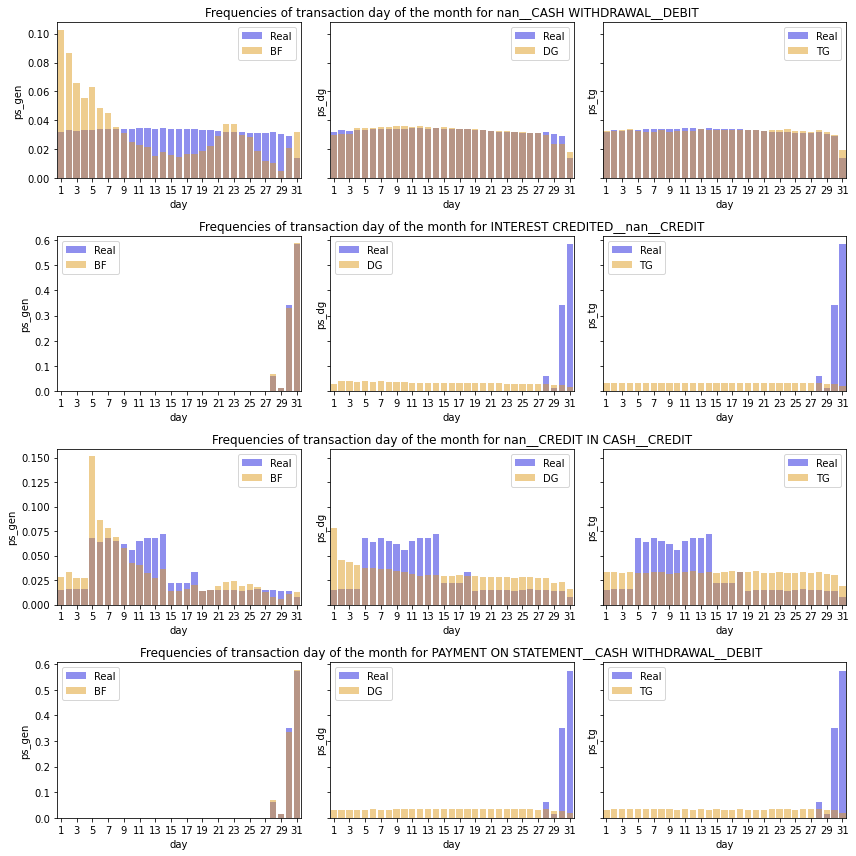

In [95]:
field1 = 'tcode'
field2 = 'day'
plot_sort_by = "counts_real"
plot_n = 32

rows = 4

fig, ax = plt.subplots(rows,3 , figsize=(12, 3 * rows), sharey='row', sharex="row")


f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))



# make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, **barplot_params)



combo_df1 = pd.merge(real_df[field1].value_counts().reset_index(), 
                    gen_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

combo_df2 = pd.merge(fgen_df[field1].value_counts().reset_index(), 
                    tg_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


combo_df_overall = pd.merge(combo_df1, 
                    combo_df2, 
                    on="index", how="outer", suffixes=("XXX", "YYY")
                   ).fillna(0.0).sort_values(by=f"{field1}_real", ascending=False)


f1_opts = combo_df_overall["index"]





for i, code_1 in enumerate(f1_opts):
    
    if i == rows:
        break
    
    combo_df1 = pd.merge(real_df[real_df[field1]==code_1][field2].value_counts().reset_index(), 
                        gen_df[gen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

    combo_df2 = pd.merge(fgen_df[fgen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        tg_df[tg_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


    combo_df = pd.merge(combo_df1, 
                        combo_df2, 
                        on="index", how="outer", suffixes=("XXX", "YYY")).fillna(0.0)
    
    
    
    print(f"{field2.capitalize()}s of real transaction with {field1} =", 
                  code_1, f"{len(real_df[real_df[field1]==code_1])/len(real_df)*100:.2f}% of real data")
    
    
    for version in ["real", 'gen', 'dg', 'tg']:

        combo_df.rename(columns={f"{field2}_{version}": f"counts_{version}"}, 
                        inplace=True)

        combo_df[f"ps_{version}"] = combo_df[f"counts_{version}"] / np.sum(combo_df[f"counts_{version}"])


    combo_df = combo_df.rename(columns={"index":field2}
                      ).sort_values(by=plot_sort_by, ascending=False
                      ).fillna(0.0)
    
    

    # fig, ax = plt.subplots(1,3, figsize = (15, 3))

    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real", ax=ax[i,0])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_gen", color="orange", alpha=0.5, label="BF", ax=ax[i,0])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[i,1])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_dg", color="orange", alpha=0.5, label="DG", ax=ax[i,1])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[i,2])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_tg", color="orange", alpha=0.5, label="TG", ax=ax[i,2])



    if i < rows - 1:
        for ii in range(3):

            # ax[i, ii].set_xlabel("")
            
            ax[i, ii].xaxis.set_major_locator(plt.MaxNLocator(16))
            ax[i, ii].legend()
        
        
    # tick_lbls = False
    # if not tick_lbls:
    #     barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
    # else:
    #     for item in barplt.get_xticklabels():
    #         item.set_rotation(90)



    # plt.title(f"Frequencies of top {plot_n} {field2}s")    
    ax[i, 1].set_title(f"Frequencies of transaction day of the month for {code_1}")    
    
    
    
for ii in range(3):

    ax[-1, ii].xaxis.set_major_locator(plt.MaxNLocator(16))
    ax[-1, ii].legend()


plt.tight_layout()
plt.show()

Dows of real transaction with tcode = nan__CASH WITHDRAWAL__DEBIT 25.94% of real data
Dows of real transaction with tcode = INTEREST CREDITED__nan__CREDIT 17.34% of real data
Dows of real transaction with tcode = nan__CREDIT IN CASH__CREDIT 14.84% of real data
Dows of real transaction with tcode = PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 14.75% of real data


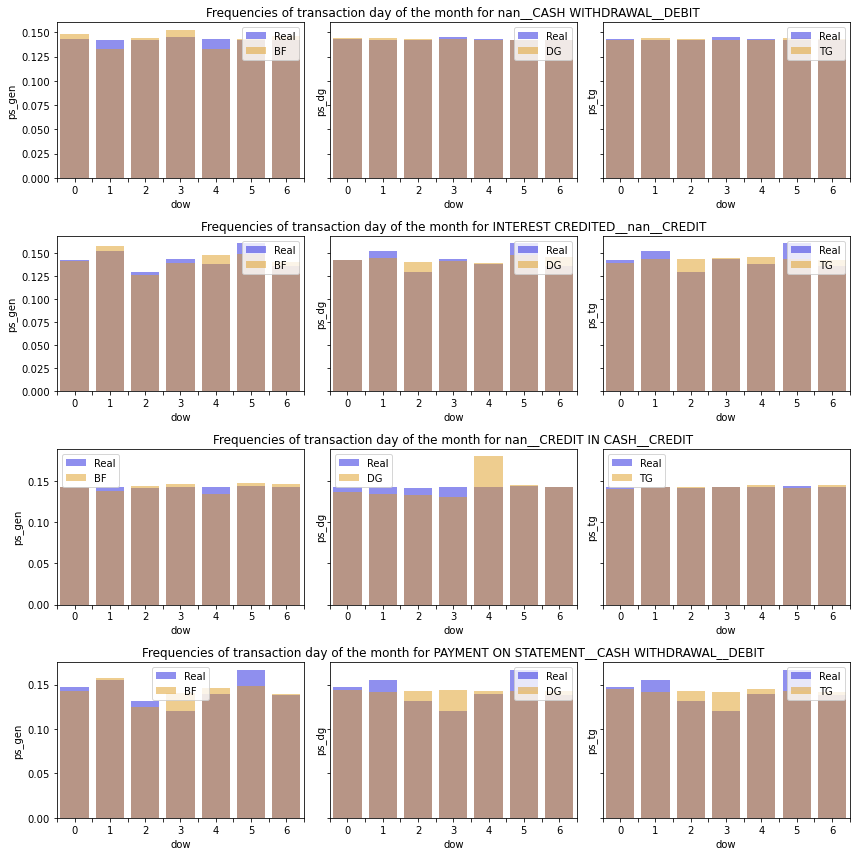

In [96]:
field1 = 'tcode'
field2 = 'dow'
plot_sort_by = "counts_real"
plot_n = 32

rows = 4

fig, ax = plt.subplots(rows,3 , figsize=(12, 3 * rows), sharey='row', sharex="row")


f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))



# make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, **barplot_params)



combo_df1 = pd.merge(real_df[field1].value_counts().reset_index(), 
                    gen_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

combo_df2 = pd.merge(fgen_df[field1].value_counts().reset_index(), 
                    tg_df[field1].value_counts().reset_index(), 
                    on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


combo_df_overall = pd.merge(combo_df1, 
                    combo_df2, 
                    on="index", how="outer", suffixes=("XXX", "YYY")
                   ).fillna(0.0).sort_values(by=f"{field1}_real", ascending=False)


f1_opts = combo_df_overall["index"]





for i, code_1 in enumerate(f1_opts):
    
    if i == rows:
        break
    
    combo_df1 = pd.merge(real_df[real_df[field1]==code_1][field2].value_counts().reset_index(), 
                        gen_df[gen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

    combo_df2 = pd.merge(fgen_df[fgen_df[field1]==code_1][field2].value_counts().reset_index(), 
                        tg_df[tg_df[field1]==code_1][field2].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_dg", "_tg")).fillna(0.0)


    combo_df = pd.merge(combo_df1, 
                        combo_df2, 
                        on="index", how="outer", suffixes=("XXX", "YYY")).fillna(0.0)
    
    
    
    print(f"{field2.capitalize()}s of real transaction with {field1} =", 
                  code_1, f"{len(real_df[real_df[field1]==code_1])/len(real_df)*100:.2f}% of real data")
    
    
    for version in ["real", 'gen', 'dg', 'tg']:

        combo_df.rename(columns={f"{field2}_{version}": f"counts_{version}"}, 
                        inplace=True)

        combo_df[f"ps_{version}"] = combo_df[f"counts_{version}"] / np.sum(combo_df[f"counts_{version}"])


    combo_df = combo_df.rename(columns={"index":field2}
                      ).sort_values(by=plot_sort_by, ascending=False
                      ).fillna(0.0)
    
    

    # fig, ax = plt.subplots(1,3, figsize = (15, 3))

    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real", ax=ax[i,0])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_gen", color="orange", alpha=0.5, label="BF", ax=ax[i,0])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[i,1])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_dg", color="orange", alpha=0.5, label="DG", ax=ax[i,1])


    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[i,2])
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_tg", color="orange", alpha=0.5, label="TG", ax=ax[i,2])



    if i < rows - 1:
        for ii in range(3):

            # ax[i, ii].set_xlabel("")
            
            ax[i, ii].xaxis.set_major_locator(plt.MaxNLocator(16))
            ax[i, ii].legend()
        
        
    # tick_lbls = False
    # if not tick_lbls:
    #     barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
    # else:
    #     for item in barplt.get_xticklabels():
    #         item.set_rotation(90)



    # plt.title(f"Frequencies of top {plot_n} {field2}s")    
    ax[i, 1].set_title(f"Frequencies of transaction day of the month for {code_1}")    
    
    
    
for ii in range(3):

    ax[-1, ii].xaxis.set_major_locator(plt.MaxNLocator(16))
    ax[-1, ii].legend()


plt.tight_layout()
plt.show()

In [234]:
combo_df

,day,counts_real,counts_gen,counts_dg,counts_tg,ps_real,ps_gen,ps_dg,ps_tg
0,5,6124.0,1795,934,0.0,0.115948,0.164815,0.032882,0.0
1,9,5931.0,875,972,0.0,0.112293,0.080342,0.034219,0.0
2,14,5513.0,1450,930,0.0,0.104379,0.133137,0.032741,0.0
3,13,5498.0,1044,937,0.0,0.104095,0.095859,0.032987,0.0
4,10,5486.0,940,945,0.0,0.103868,0.086310,0.033269,0.0
5,12,5176.0,1090,1044,0.0,0.097999,0.100083,0.036754,0.0
6,7,5051.0,963,928,0.0,0.095632,0.088422,0.032670,0.0
7,11,4933.0,867,987,0.0,0.093398,0.079607,0.034747,0.0
8,8,4581.0,825,960,0.0,0.086733,0.075751,0.033797,0.0
9,6,4524.0,866,908,0.0,0.085654,0.079515,0.031966,0.0


In [214]:
    

# combo_df.rename(columns={"index":field})
    
for version in ["real", 'gen', 'dg', 'tg']:
    
    combo_df.rename(columns={f"{field2}_{version}": f"counts_{version}"}, 
                    inplace=True)
    
    combo_df[f"ps_{version}"] = combo_df[f"counts_{version}"] / np.sum(combo_df[f"counts_{version}"])
    
    
combo_df = combo_df.rename(columns={"index":field2}).sort_values(by=plot_sort_by, ascending=False)

combo_df

,day,counts_real,counts_gen,counts_dg,counts_tg,ps_real,ps_gen,ps_dg,ps_tg
0,31,202082,81687,16458,7640,0.191308,0.204217,0.017298,0.019100
1,30,128499,46912,22855,11890,0.121648,0.117280,0.024021,0.029725
2,12,60723,15530,32265,13363,0.057485,0.038825,0.033911,0.033407
3,14,48006,10052,31762,13266,0.045446,0.025130,0.033382,0.033165
4,13,47420,8152,31869,13446,0.044892,0.020380,0.033495,0.033615
5,5,47250,35378,33719,13087,0.044731,0.088445,0.035439,0.032717
6,6,46226,21359,33418,13055,0.043761,0.053398,0.035123,0.032637
7,9,45358,15026,32892,13006,0.042940,0.037565,0.034570,0.032515
8,8,45188,17782,33134,13108,0.042779,0.044455,0.034824,0.032770
9,7,45022,19482,33130,12963,0.042622,0.048705,0.034820,0.032407


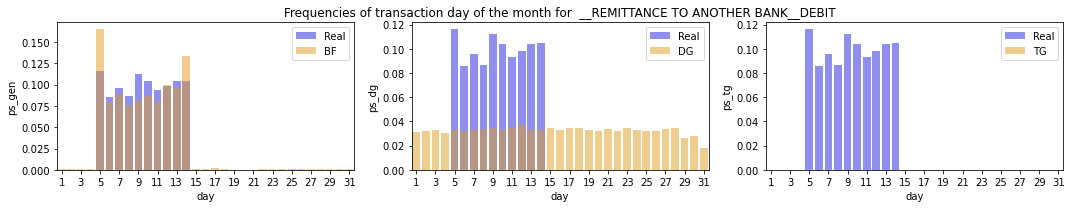

In [244]:

fig, ax = plt.subplots(1,3, figsize = (15, 3))

barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real", ax=ax[0])
barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_gen", color="orange", alpha=0.5, label="BF", ax=ax[0])


barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[1])
barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_dg", color="orange", alpha=0.5, label="DG", ax=ax[1])


barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_real", color="b", alpha=0.5, label="Real",   ax=ax[2])
barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field2, y="ps_tg", color="orange", alpha=0.5, label="TG", ax=ax[2])



# tick_lbls = False
# if not tick_lbls:
#     barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
# else:
#     for item in barplt.get_xticklabels():
#         item.set_rotation(90)

for i in range(3):

    ax[i].xaxis.set_major_locator(plt.MaxNLocator(16))
    ax[i].legend()

# plt.title(f"Frequencies of top {plot_n} {field2}s")    
ax[1].set_title(f"Frequencies of transaction day of the month for {code_1}")    


plt.tight_layout()
plt.show()


In [192]:

def make_barplot(real_df, gen_df, field, plot_n = 30, plot_sort_by = "counts_real", tick_lbls= False, ax=None):

    combo_df = pd.merge(real_df[field].value_counts().reset_index(), 
                        gen_df[field].value_counts().reset_index(), 
                        on="index", how="outer", suffixes=("_real", "_gen")).fillna(0.0)
    
    combo_df.rename(columns={"index":field,
                            field + "_real": "counts_real",
                            field + "_gen": "counts_gen",}, inplace=True)

    combo_df["ps_real"] = combo_df["counts_real"] / np.sum(combo_df["counts_real"])

    combo_df["ps_gen"] = combo_df["counts_gen"] / np.sum(combo_df["counts_gen"])

    if ax is None:
        plt.figure(figsize=(14,6))

    combo_df = combo_df.sort_values(by=plot_sort_by, ascending=False)

    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field, y="ps_real", color="b", alpha=0.5, label="real", ax=ax)
    barplt = sns.barplot(data = combo_df.iloc[:plot_n],x=field, y="ps_gen", color="orange", alpha=0.5, label="gen", ax=ax)


    if not tick_lbls:
        barplt.set_xticklabels(["" for _ in barplt.get_xticklabels()])
    else:
        for item in barplt.get_xticklabels():
            item.set_rotation(90)

    plt.title(f"Frequencies of top {plot_n} {field}s")    
    



def compute_2d_categorical_metrics(real_df, gen_df, field1, field2, pseudo_counts = 0.0, plot = False, barplot_params = {}, 
                                   compute_cont_metrics = True, plot_ecdfs = False, plot_ecdf_params = {}):


    f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))
    f2_opts = set(real_df[field2].unique()).union(set(gen_df[field2].unique()))

    n_opts_total = len(f1_opts) * len(f2_opts)


    kl_r_m = 0.
    kl_g_m = 0.
    entr_r = 0.
    entr_g = 0.
    l1_d = 0.
    l2_d = 0.
    count_g = 0.
    count_r = 0.
    
    observed_opts = 0
    
    cont_metric_results = {}
    
    
    for code_1 in f1_opts:
        
        if plot:
            print(f"{field2.capitalize()}s of real transaction with {field1} =", 
                  code_1, f"{len(real_df[real_df[field1]==code_1])/len(real_df)*100:.2f}% of real data")
            if plot_ecdfs:
                fig, ax = plt.subplots(1, 3, figsize=(24,7), gridspec_kw={'width_ratios': [3, 1, 1]})
#                 fig, ax = plt.subplots(1, 2, figsize=(20,7), gridspec_kw={'width_ratios': [3, 1]})
                
                make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, ax=ax[0], **barplot_params)
                ax[0].legend()
            
            
                plot_ecdf(real_df[real_df[field1]==code_1]['raw_amount'], plot_params={"label":"real"}, ax=ax[2])
                plot_ecdf(gen_df[gen_df[field1]==code_1]['raw_amount'], plot_params={"label":"gen"}, ax=ax[2])
                
                ax[2].legend()
                ax[2].set_title(f"ECDF") # of amounts with {field1} = {code_1}
                
                ax[1].hist(real_df[real_df[field1]==code_1]['raw_amount'], label="real", bins = "auto", density=True, alpha=0.5)
                ax[1].hist(gen_df[gen_df[field1]==code_1]['raw_amount'], label="gen", bins="auto", density=True, alpha=0.5)

                ax[1].legend()
                ax[1].set_title(f"Hist of transaction amounts with \n {field1} = {code_1}")

            else:
                make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, **barplot_params)
                ax = [None, None]
                
            plt.show()
                
#             make_barplot(real_df[real_df[field1]==code_1], gen_df[gen_df[field1]==code_1], field=field2, ax=ax, **barplot_params)


# New - check non-memorization

In [104]:
gb_real = real_df[["account_id", "amount", "tcode", "days_passed"]].groupby("account_id")
gb_gen = gen_df[["account_id", "amount", "tcode", "days_passed"]].groupby("account_id")

In [105]:
for _, dfr in gb_real:
    rdata = dfr.to_numpy()[:,[1,2]]
    for _, dfg in gb_gen:
        gdata = dfg.to_numpy()[:,[1,2]]
    break

In [110]:
window = 5
alpha = 0.05


# match = False
start_time = time.time()

n_compares = 0
n_tcode_seq_match = 0
n_real_df = 0

matches_at = []

for dfr_count, (dfr_i, dfr) in enumerate(gb_real):
    n_real_df +=1 
    if n_real_df % 250 == 0:
        print("Begin with real df", dfr_count, f"{n_real_df} complete out of {len(gb_real)}")
        print(f"Time so far {time.time() - start_time:.2f}  ({(time.time() - start_time) / (n_real_df):.2f})" )
    rdata = dfr.to_numpy()[:,[1,2]]
    ramt = rdata[:,0].astype(float)
    rcode = rdata[:,1]
    
    
    for dfg_i, dfg in gb_gen:
        gdata = dfg.to_numpy()[:,[1,2]]
        gamt = gdata[:,0].astype(float)
        gcode = gdata[:,1]
        
        
        for ri in range(len(rdata)-window+1):
            for gi in range(len(gdata)-window+1):
                n_compares += 1
                
#                 if len(rcode[ri:ri+window]) == len(gcode[gi:gi+window]):
#                     print("good")
#                 else:
#                     print("Bad", ri, gi, window, len(rcode[ri:ri+window]), len(gcode[gi:gi+window]), len(rdata))
                if np.all(rcode[ri:ri+window] == gcode[gi:gi+window]):
#                     print("Match tcodes!")
                    n_tcode_seq_match += 1 
    

            
            
                    if np.allclose(ramt[ri:ri+window], gamt[gi:gi+window], rtol=alpha, atol=0.0):
                        print("Match tcodes and amounts !")
                        print(f"Took {time.time() - start_time:.2f} secs to find match!")
                        
                        matches_at.append((dfr_count, dfr_i, dfr, dfg_i, dfg, ri, gi ))
                        
#                         raise("quit")
                

Begin with real df 249 250 complete out of 4500
Time so far 80241.44  (320.97)
Match tcodes and amounts !
Took 122749.30 secs to find match!
Begin with real df 499 500 complete out of 4500
Time so far 151352.50  (302.71)
Match tcodes and amounts !
Took 162809.05 secs to find match!
Begin with real df 749 750 complete out of 4500
Time so far 239391.83  (319.19)


KeyboardInterrupt: 

In [111]:
n_compares, n_tcode_seq_match, n_real_df

(32274452016, 10822407, 751)

In [113]:
n_tcode_seq_match / n_compares *100

0.03353242680816025

In [114]:
len(matches_at)

2

In [115]:
2 /  n_compares *100

6.19685192178787e-09

## BF result

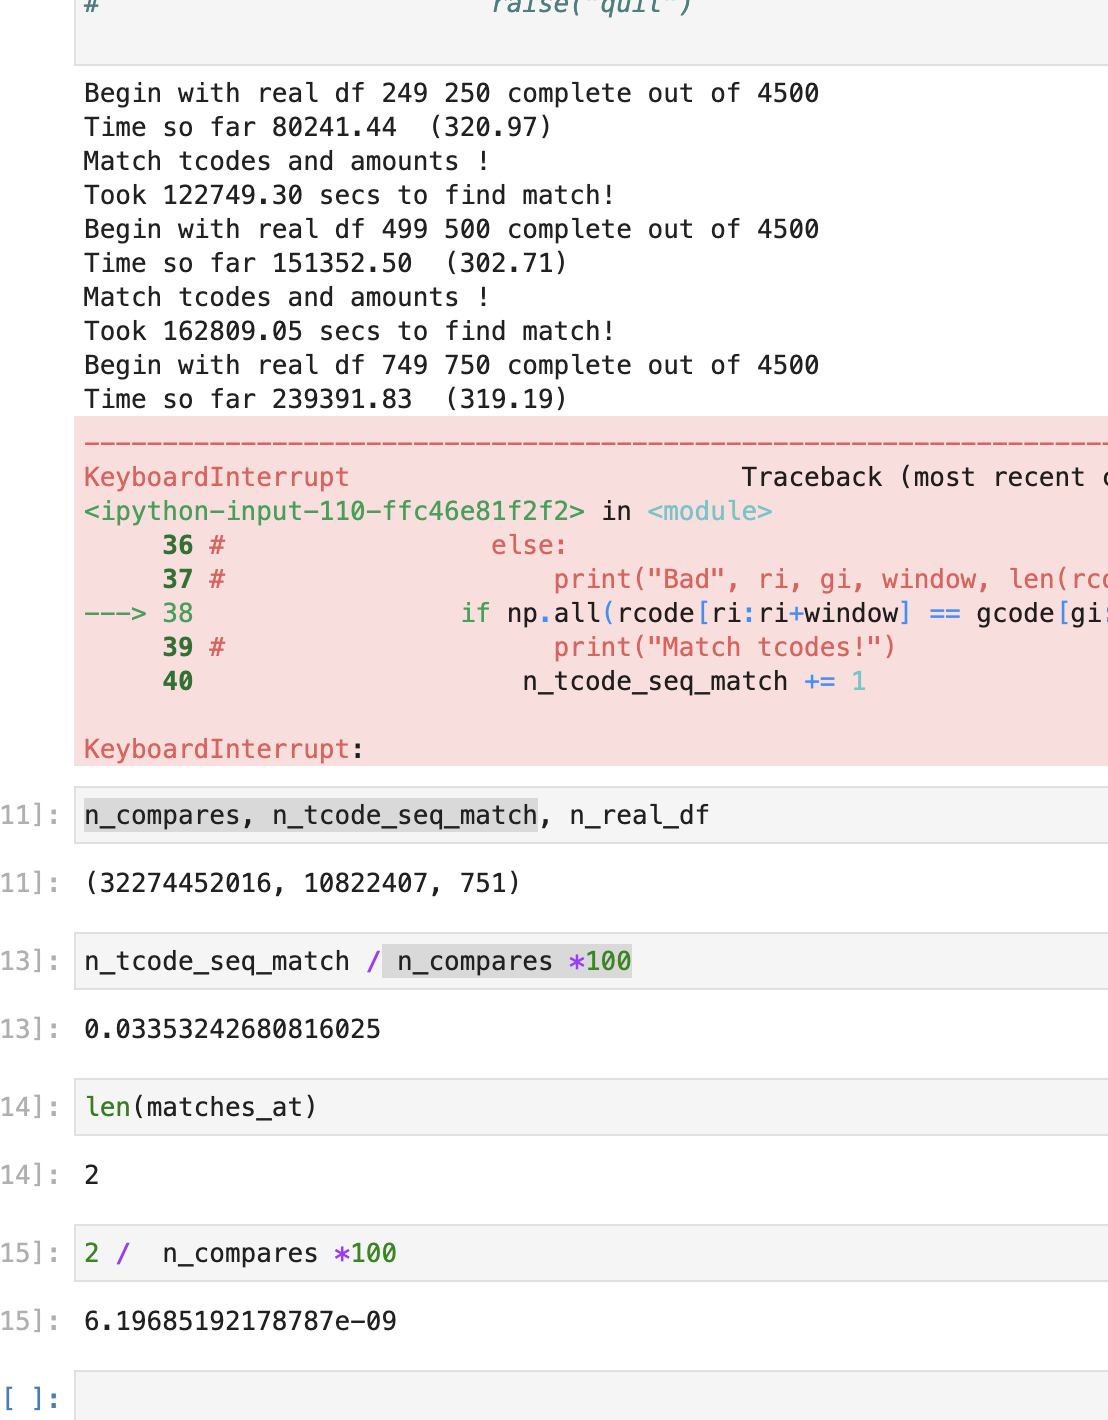

In [118]:
gb_fgen = fgen_df[["account_id", "amount", "tcode", "days_passed"]].groupby("account_id")

In [119]:
window = 5
alpha = 0.05


# match = False
start_time = time.time()

n_compares = 0
n_tcode_seq_match = 0
n_real_df = 0

matches_at = []

for dfr_count, (dfr_i, dfr) in enumerate(gb_real):
    n_real_df +=1 
    if n_real_df % 250 == 0:
        print("Begin with real df", dfr_count, f"{n_real_df} complete out of {len(gb_real)}")
        print(f"Time so far {time.time() - start_time:.2f}  ({(time.time() - start_time) / (n_real_df):.2f})" )
    rdata = dfr.to_numpy()[:,[1,2]]
    ramt = rdata[:,0].astype(float)
    rcode = rdata[:,1]
    
    
    for dfg_i, dfg in gb_fgen:
        gdata = dfg.to_numpy()[:,[1,2]]
        gamt = gdata[:,0].astype(float)
        gcode = gdata[:,1]
        
        
        for ri in range(len(rdata)-window+1):
            for gi in range(len(gdata)-window+1):
                n_compares += 1
                
#                 if len(rcode[ri:ri+window]) == len(gcode[gi:gi+window]):
#                     print("good")
#                 else:
#                     print("Bad", ri, gi, window, len(rcode[ri:ri+window]), len(gcode[gi:gi+window]), len(rdata))
                if np.all(rcode[ri:ri+window] == gcode[gi:gi+window]):
#                     print("Match tcodes!")
                    n_tcode_seq_match += 1 
    

            
            
                    if np.allclose(ramt[ri:ri+window], gamt[gi:gi+window], rtol=alpha, atol=0.0):
                        print("Match tcodes and amounts !")
                        print(f"Took {time.time() - start_time:.2f} secs to find match!")
                        
                        matches_at.append((dfr_count, dfr_i, dfr, dfg_i, dfg, ri, gi ))
                        
#                         raise("quit")
                

KeyboardInterrupt: 

In [120]:
n_compares, n_tcode_seq_match, n_real_df

(31256357834, 19304491, 144)

In [121]:
n_tcode_seq_match / n_compares *100

0.06176180571813453

In [122]:
len(matches_at)

0

In [123]:
2 /  n_compares *100

6.398698180452883e-09

In [ ]:
n_compares / 10**9

In [ ]:
n_compares, n_tcode_seq_match, n_real_df

In [ ]:
ramt[ri:ri+window], gamt[gi:gi+window]

In [ ]:
np.allclose(ramt[ri:ri+window], gamt[gi:gi+window])

In [ ]:
rdata[ri:ri+window,0] , gdata[gi:gi+window, 0]

In [ ]:
np.allclose(rdata[ri:ri+window,0].astype(float) , gdata[gi:gi+window, 0].astype(float), atol=0, rtol=0.05)

In [ ]:
rdata[ri:ri+window, 1] == gdata[gi:gi+window, 1]

In [ ]:
rdata[ri:ri+window] , gdata[gi:gi+window]

In [ ]:
dfr[["amount", "tcode"]]

In [ ]:
rdata

In [ ]:
rdata.shape

In [ ]:
len(rdata)

In [ ]:
for ri in range(len(rdata)-window+1):
    rdata[ri:ri+window]
    for gi in range(len(rdata)-window+1):
        
        if np.all(rdata[ri:ri+window, 1] == gdata[gi:gi+window, 1]):
            print("Match !!")

In [ ]:
len(rdata[ri:ri+window, 1])

In [ ]:
np.all(rdata[ri:ri+window, 1] == gdata[gi:gi+window, 1])

In [ ]:
dfg[["amount", "tcode"]].iloc[gi:gi+window].asarray()

In [ ]:
dfr.to_numpy()